In [1]:
library(ggplot2)
library(repr)
library(tidybayes)
library(tidyverse)
library(patchwork)
library(rjags)
options(repr.plot.width=10, repr.plot.height=8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Exercise 1:

### given the following un-normalized posterior distribution

$$
g(\theta|x) \propto \frac{1}{2} \exp{(-\frac{(\theta + 3)^2}{2})} + \frac{1}{2} \exp{(-\frac{(\theta - 3)^2}{2})}
$$

### - draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

Metropolis-Hasting algorithm:

1) Initialize the chain at some value
2) Draw a random sample from the distribution Q(s∣$\theta$)
3) Decide whether to accept or not the new candidate sample on the basis of the Metropolis ratio:

$$
\rho = \frac{f(s)}{f(\theta_t)} \frac{Q(\theta_t|s)}{Q(s|\theta_t)}
$$

- if $\rho \geq 1 $ the new candidate is accepted and $\theta_{t+1} = s$

- if $\rho < 1$ we only accept it with probability $\rho$:
  - draw $u ∼ U (0, 1)$ and set $\theta_{t+1} = s$ only if $u \leq \rho$.

if $s$ is not accepted, we set $\theta_{t+1} = \theta_t$, i.e. the existing sample in the chain is repeated.

### - use a Norm (0, 1) as random-walk candidate density

In [2]:
g_function <- function(theta){
    return(0.5*exp(-0.5*(theta+3)^2) +
                  0.5*exp(-0.5*(theta-3)^2))
}

metropolis_g <- function(theta){
    return(log10(g_function(theta)))
}

In [3]:
metropolis_1dim <- function(func, theta_init, n_sample, sigma, burnin, thin){
    theta_cur <- theta_init
    func_Cur <- func(theta_cur)
    func_Samp <- matrix(data=NA, nrow=n_sample, ncol=2)
    n_accept <- 0
    rate_accept <- 0.0
    i <- 0
    
    for (n in 1:n_sample) {
        theta_prop <- rnorm(1, theta_cur, sigma)

        func_Prop <- func(theta_prop)

        log_MR <- func_Prop - func_Cur
        
        if (log_MR >=0 || log_MR > log10(runif(1))) {
            theta_cur <- theta_prop
            func_Cur <- func_Prop
            n_accept <- n_accept + 1
        }
        
        if (n > burnin & n%%thin == 0){
        
            func_Samp[i, 1] <- func_Cur
            func_Samp[i, 2] <- theta_cur
            
            i <- i+1
            
            }
        
        }
    
    rate_accept <- n_accept/n_sample
    func_Samp <- na.omit(func_Samp)
    
    cat('Values accepted:', rate_accept, '\n')
    
    return(func_Samp)
}

Plotting to see function from which we want to sample:

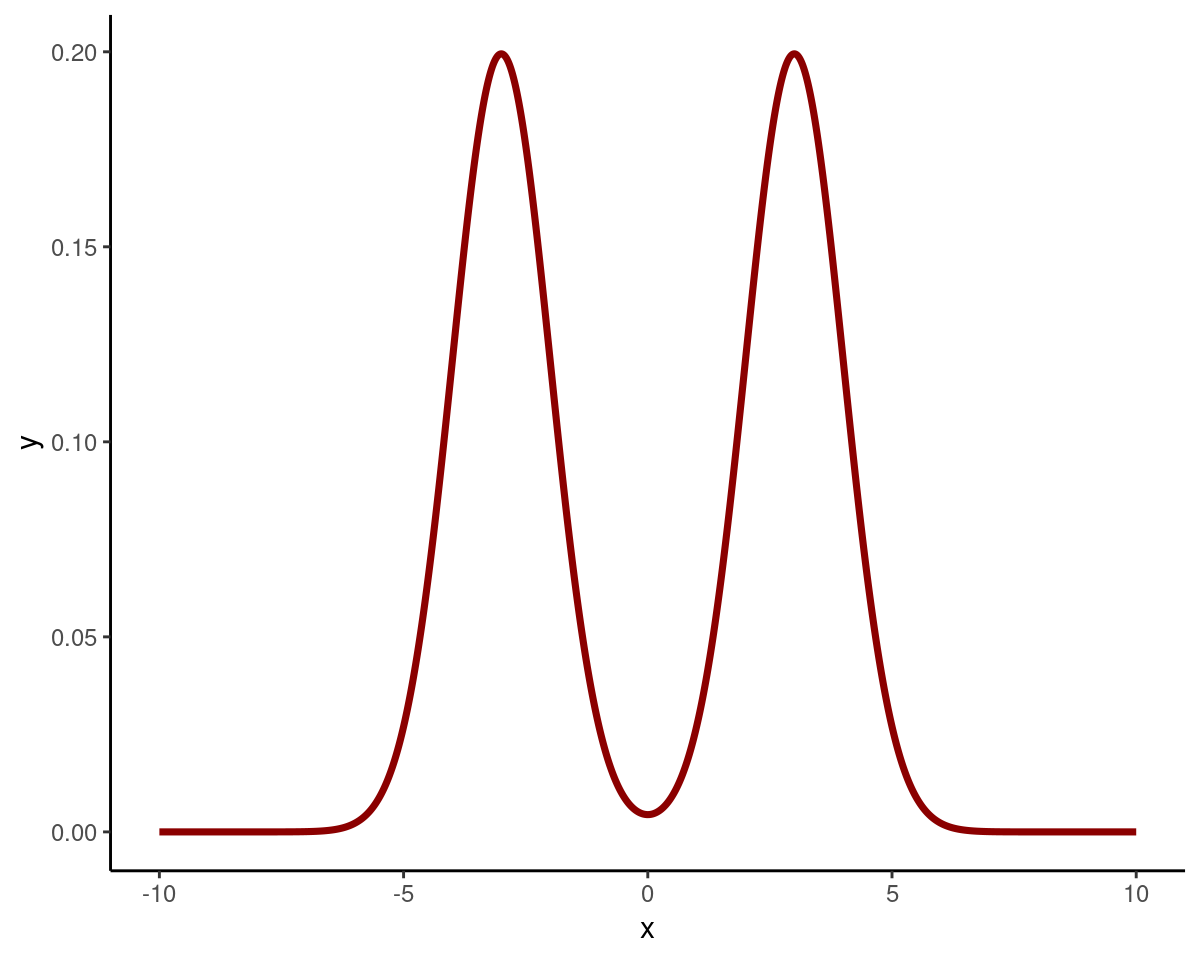

In [4]:
x <- seq(-10, 10, by = 0.001)
y <- g_function(x)/sum(0.001*g_function(x))

df_func = data.frame(x = x, y = y)

ggplot() +
geom_line(data = df_func, aes(x = x, y = y), color='darkred', linewidth=2) +
theme_classic(base_size=18)

Run Metropolis-Hastings algorithm:

In [5]:
theta_init <- 0
sample_sig <- 1
n_sample <- 10^6
burnin <- 0 #no burn-in
thin <- 1 #no thinning
set.seed(2072050)
chain <- metropolis_1dim(func = metropolis_g,
                         theta_init = theta_init,
                         n_sample = n_sample,
                         sigma = sample_sig^2,
                         burnin = burnin,
                         thin = thin)

Values accepted: 0.711261 


### - plot the sampled distribution

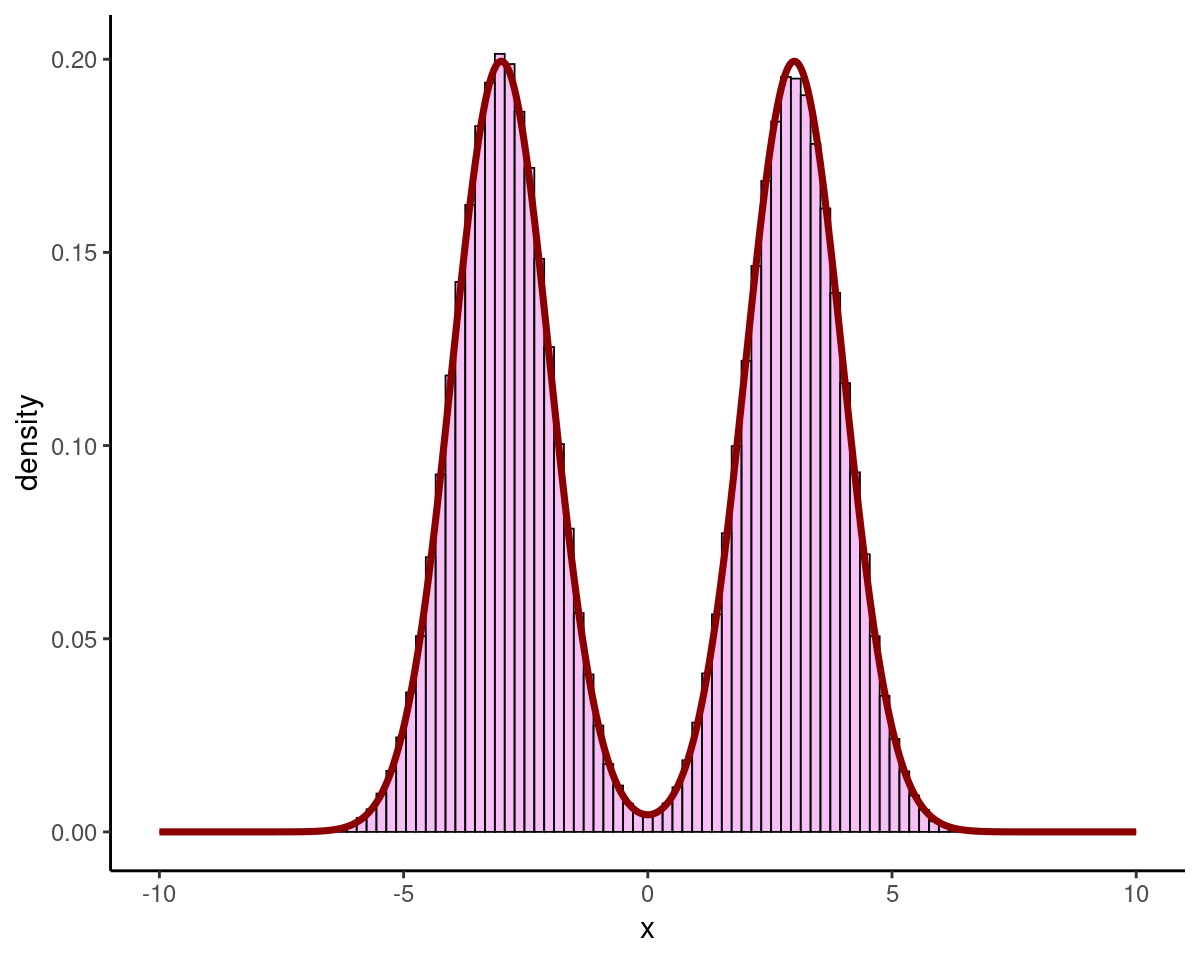

In [6]:
df_chain = data.frame(x = chain[,2], y = chain[,1])


ggplot() +
geom_histogram(data = df_chain, aes(x = x, y = after_stat(density)),
               bins=100, color = 'black',
               fill='violet', alpha=0.5) +
geom_line(data = df_func, aes(x = x, y = y), color='darkred', linewidth=2) +
theme_classic(base_size=18)

### - analyze the chain with the CODA package and plot the chain autocorrelation

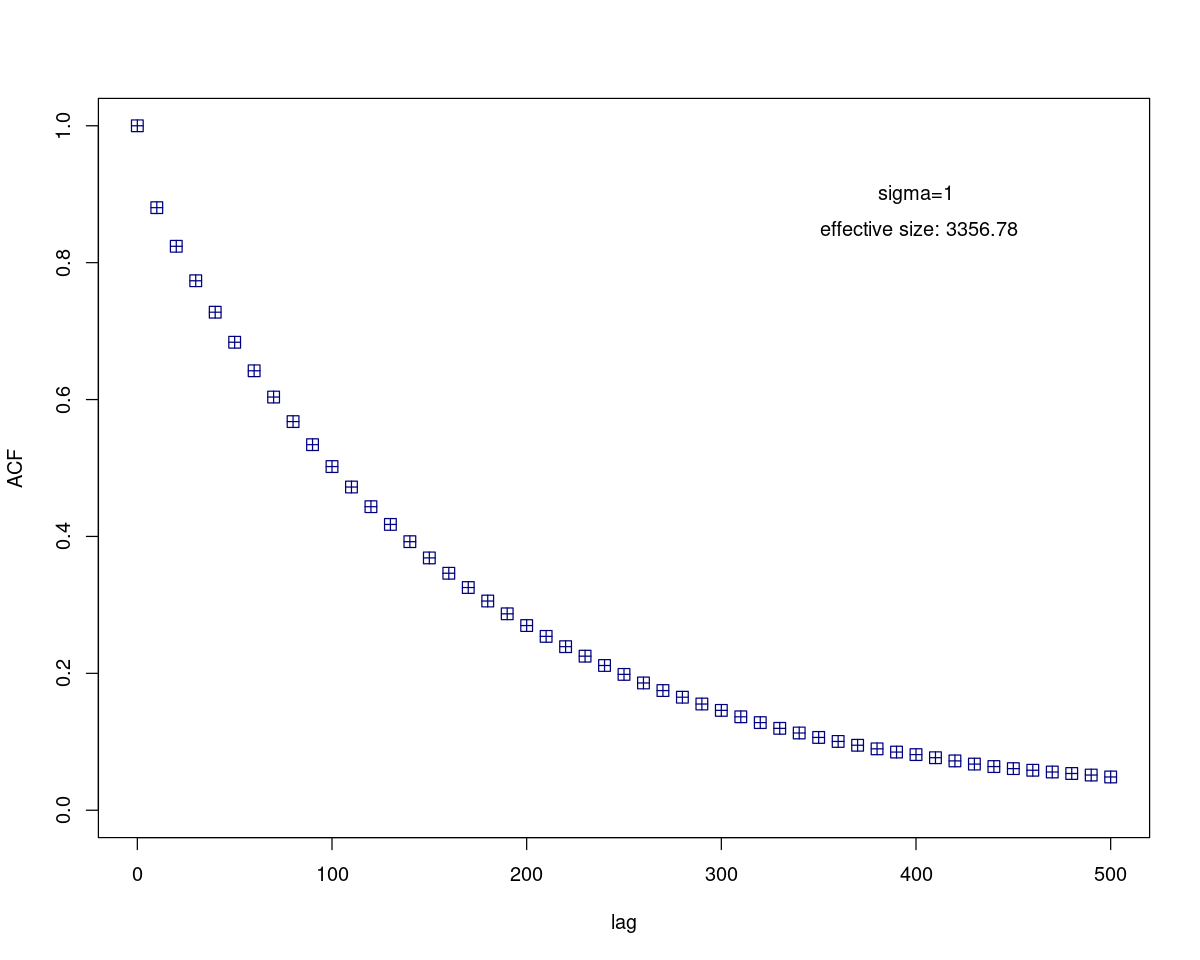

In [7]:
chain_coda <- as.mcmc(chain[,2])
my_lags = seq(0,500,10)
y1 <- autocorr(chain_coda, lags=my_lags)
plot(my_lags, y1, ylim=c(0,1),
pch=12, col='navy',
xlab='lag', ylab='ACF', cex=1.3)
text(400,0.9, paste('sigma=1'))
text(400,0.85,
sprintf (" effective size: %.2f",
effectiveSize(chain_coda)))

### - try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters?

In [8]:
explore <- function(theta_init, sample_sig, n_sample, burnin, thin){
    
    chain <- metropolis_1dim(func = metropolis_g,
                         theta_init = theta_init,
                         n_sample = n_sample,
                         sigma = sample_sig^2,
                         burnin = burnin,
                         thin = thin)
    
    df_chain = data.frame(x = chain[,2], y = chain[,1])
    
    p1 <- ggplot() +
        geom_histogram(data = df_chain, aes(x = x, y = after_stat(density)),
                       bins=100, color = 'black',
                       fill='violet', alpha=0.5) +
        geom_density(data = df_chain, aes(x = x, y = after_stat(density)),
                     lwd = 1.5, linetype = 2, colour = 'black') +
        geom_line(data = df_func, aes(x = x, y = y), color='darkred', linewidth=2) +
        theme_classic(base_size=18) +
        scale_y_continuous(expand = c(0, 0)) +
        ggtitle('Burn-in:', burnin)
    

    chain_coda <- as.mcmc(chain[,2])
    my_lags = seq(0,500,10)
    y1 <- autocorr(chain_coda, lags=my_lags)
    df_l <- data.frame(x1 = my_lags, y1 = y1)
    
    p2 <- ggplot() +
        geom_point(data = df_l, aes(x = x1, y = y1), color='darkblue', size=2) +
        theme_classic(base_size=18) +
        labs(x="lag", y="ACF") +
        scale_y_continuous(expand = c(0, 0)) +
        ggtitle('Thinning: ', thin)
    
    
    print(p1+p2)
}

Values accepted: 0.711012 
Values accepted: 0.710674 


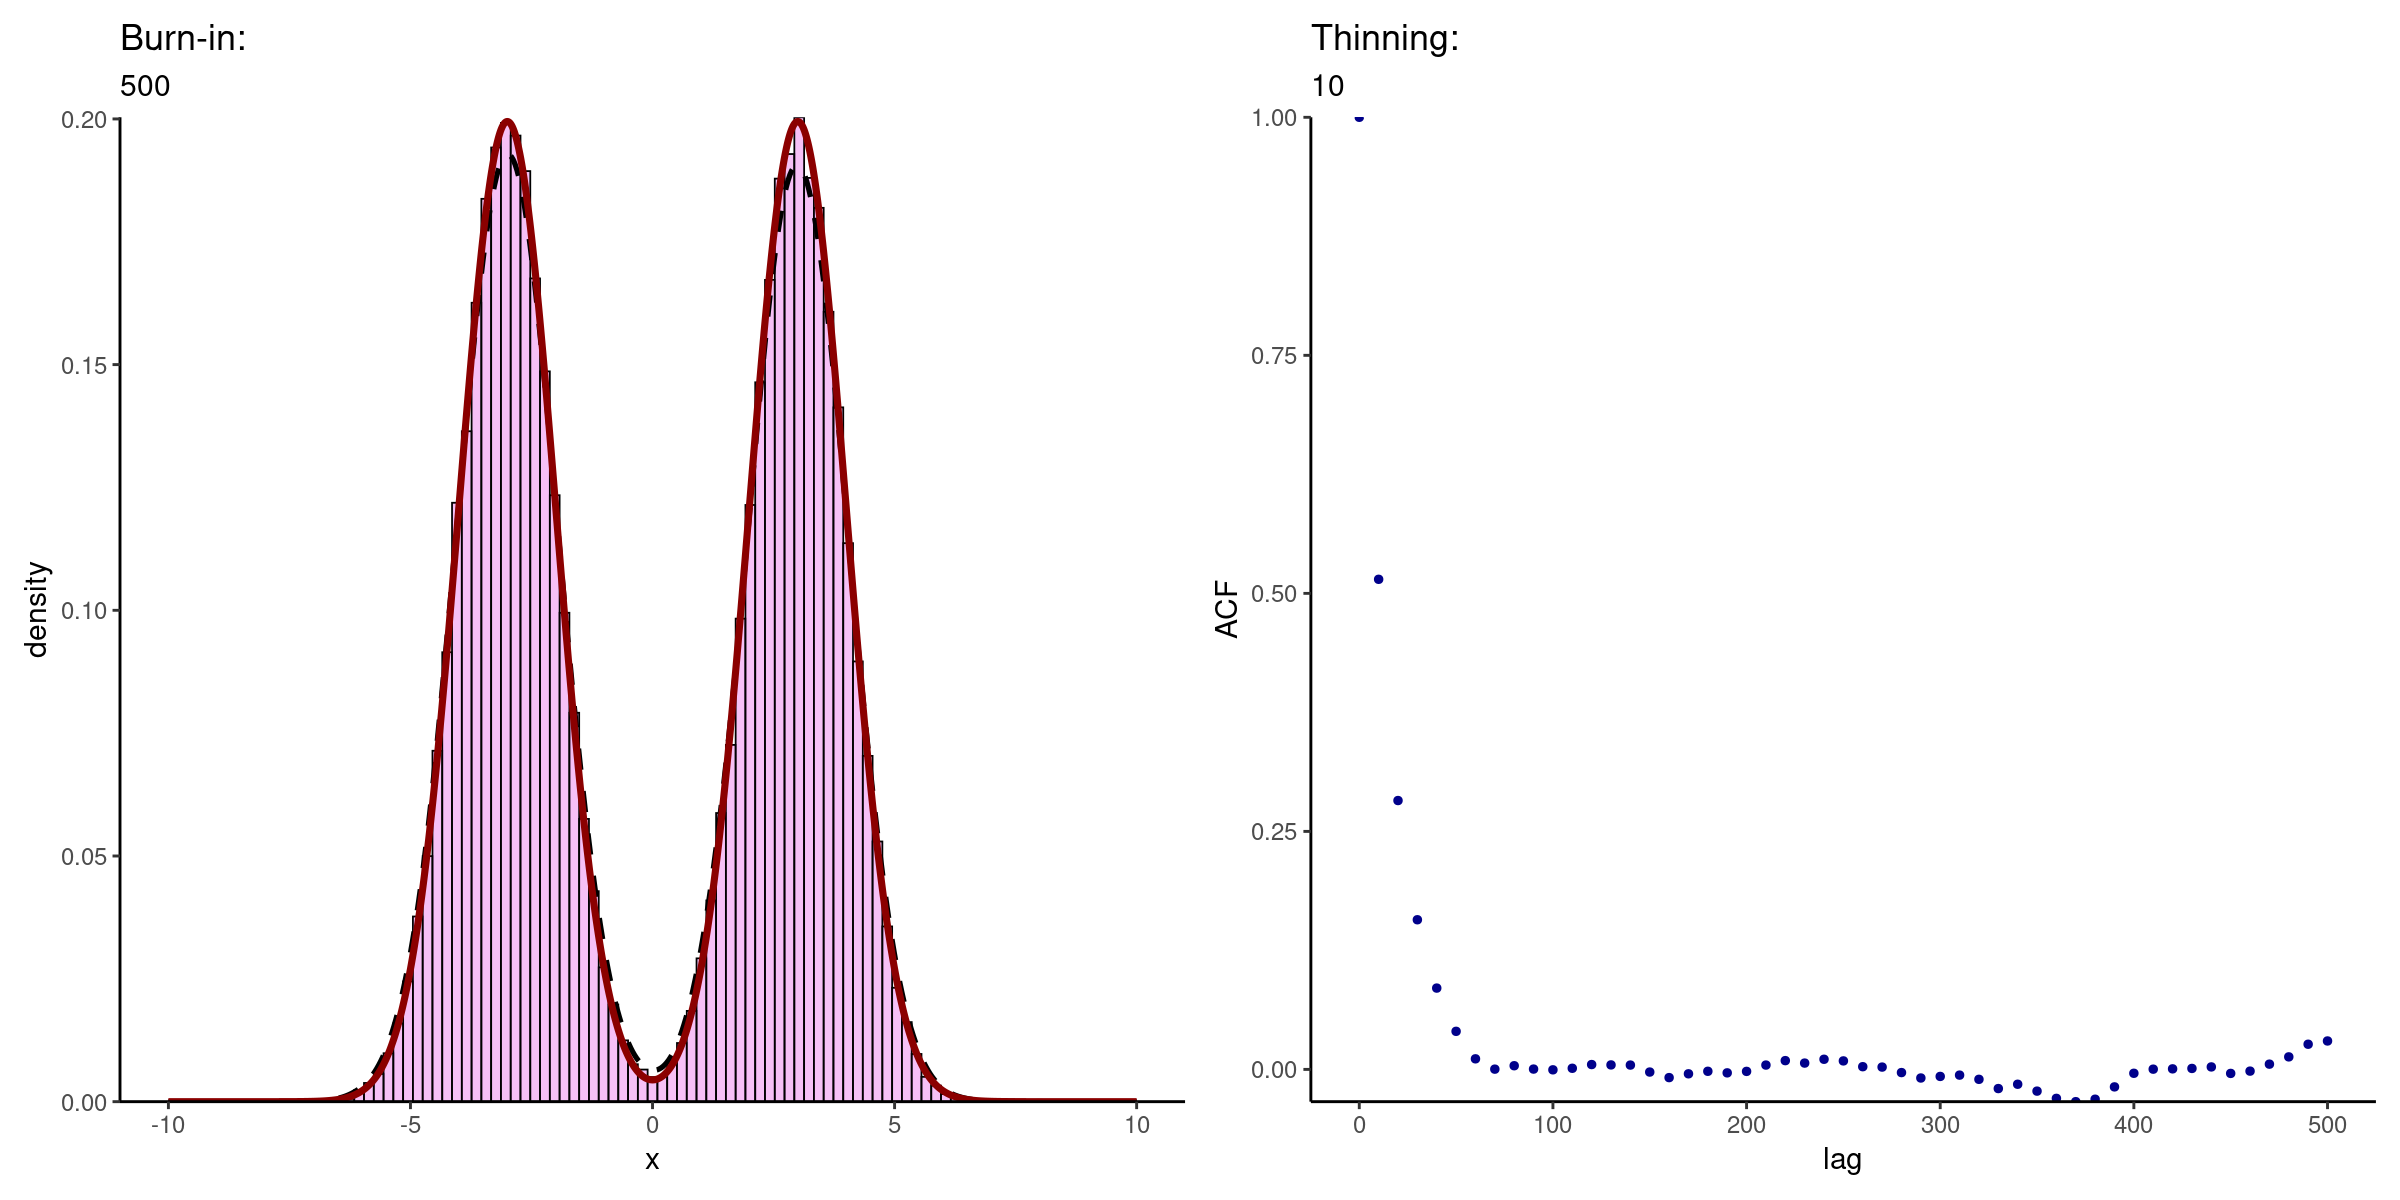

Values accepted: 0.711919 


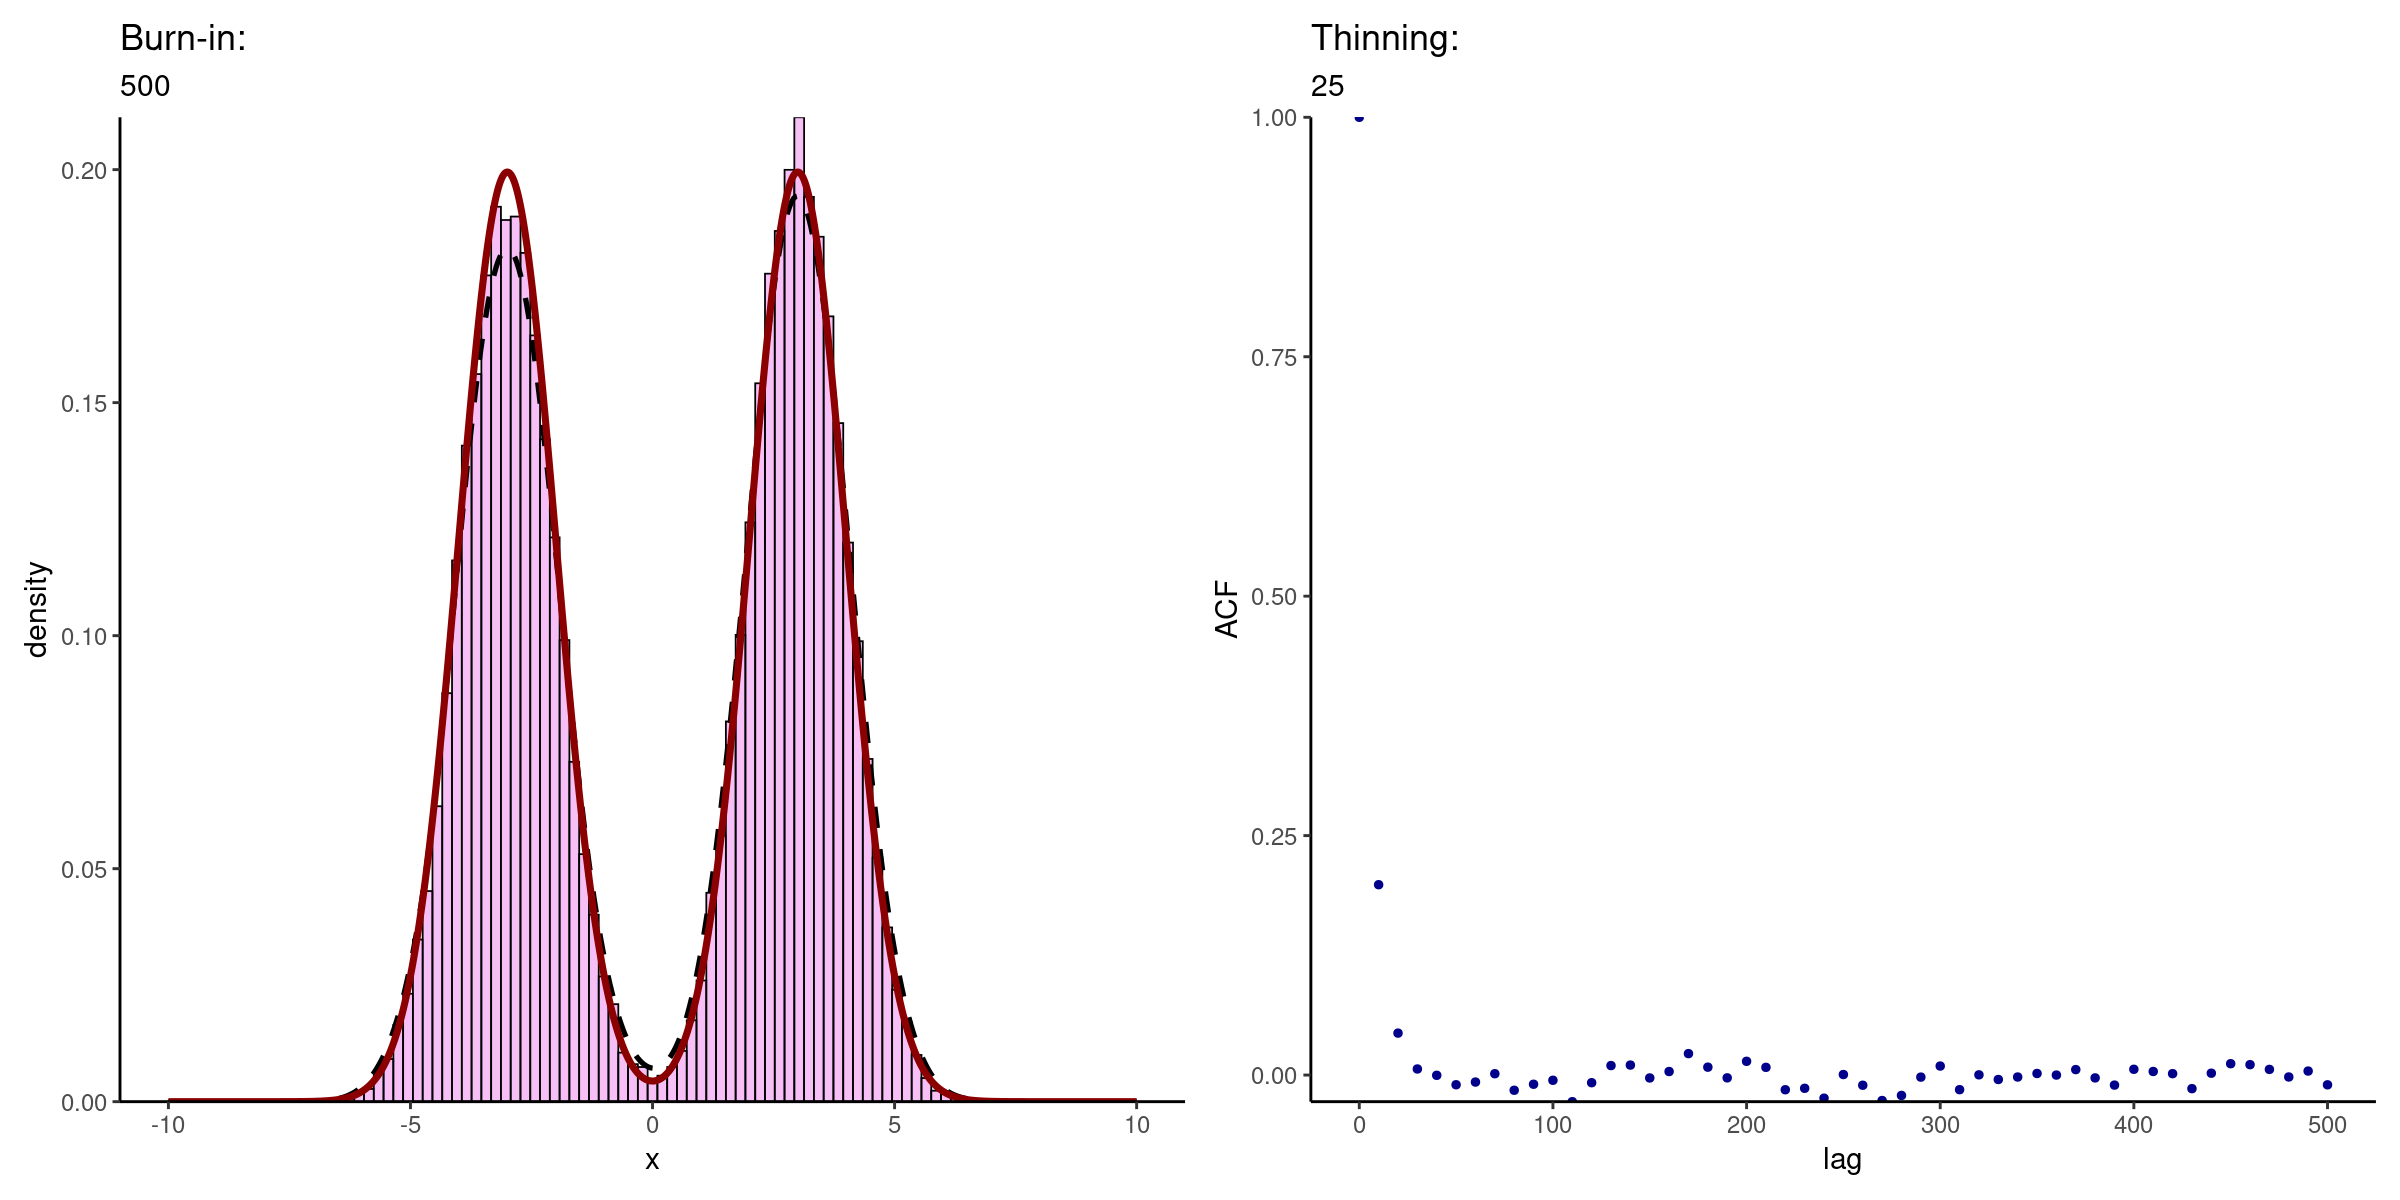

Values accepted: 0.710289 


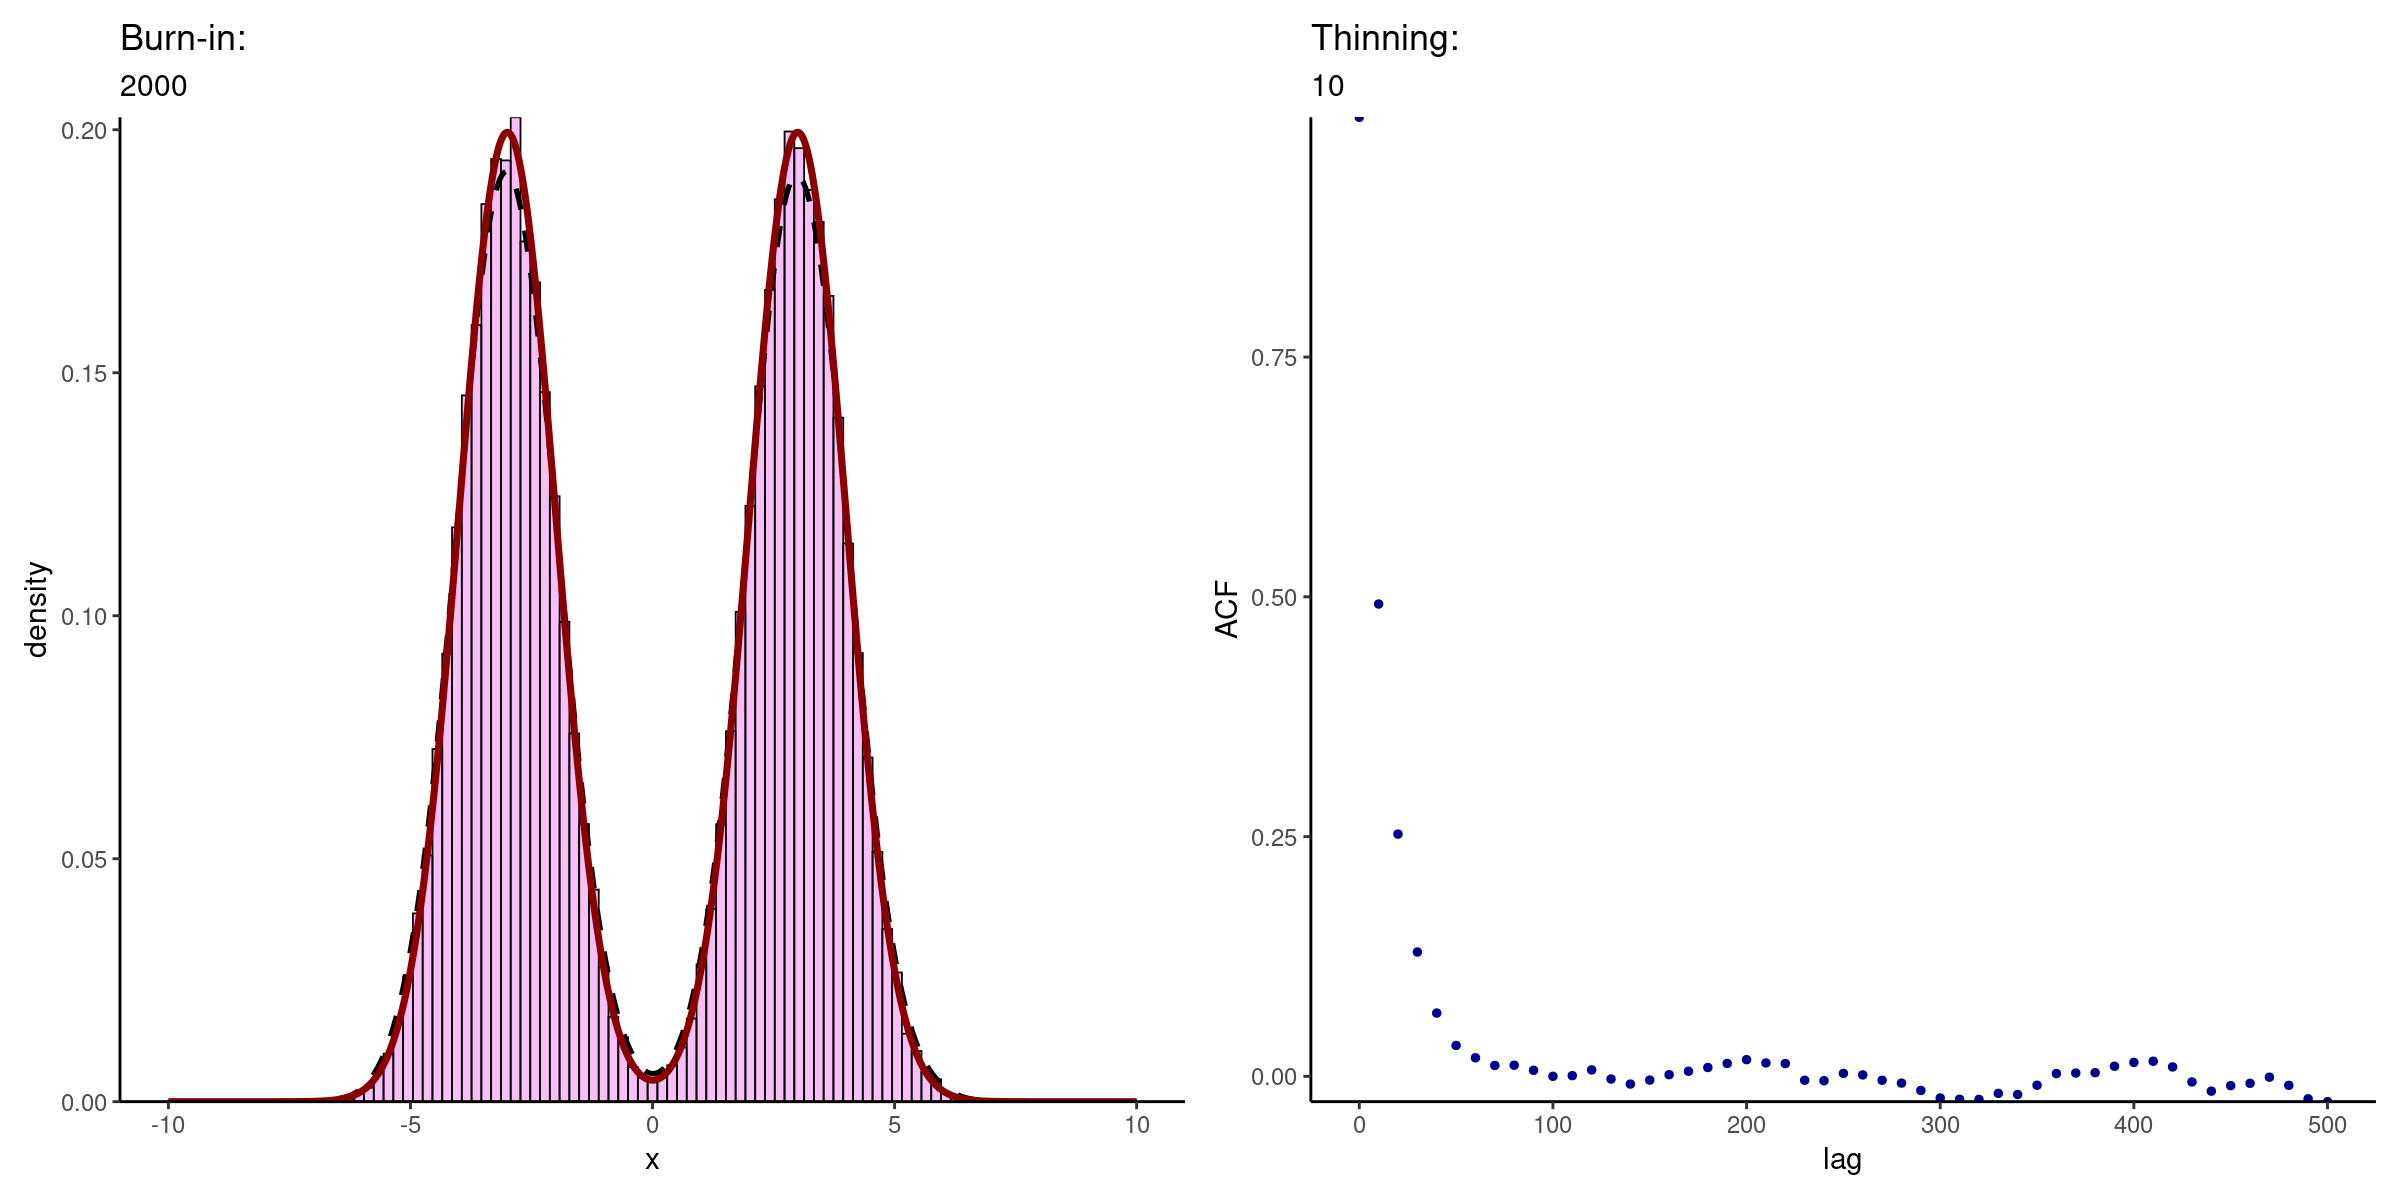

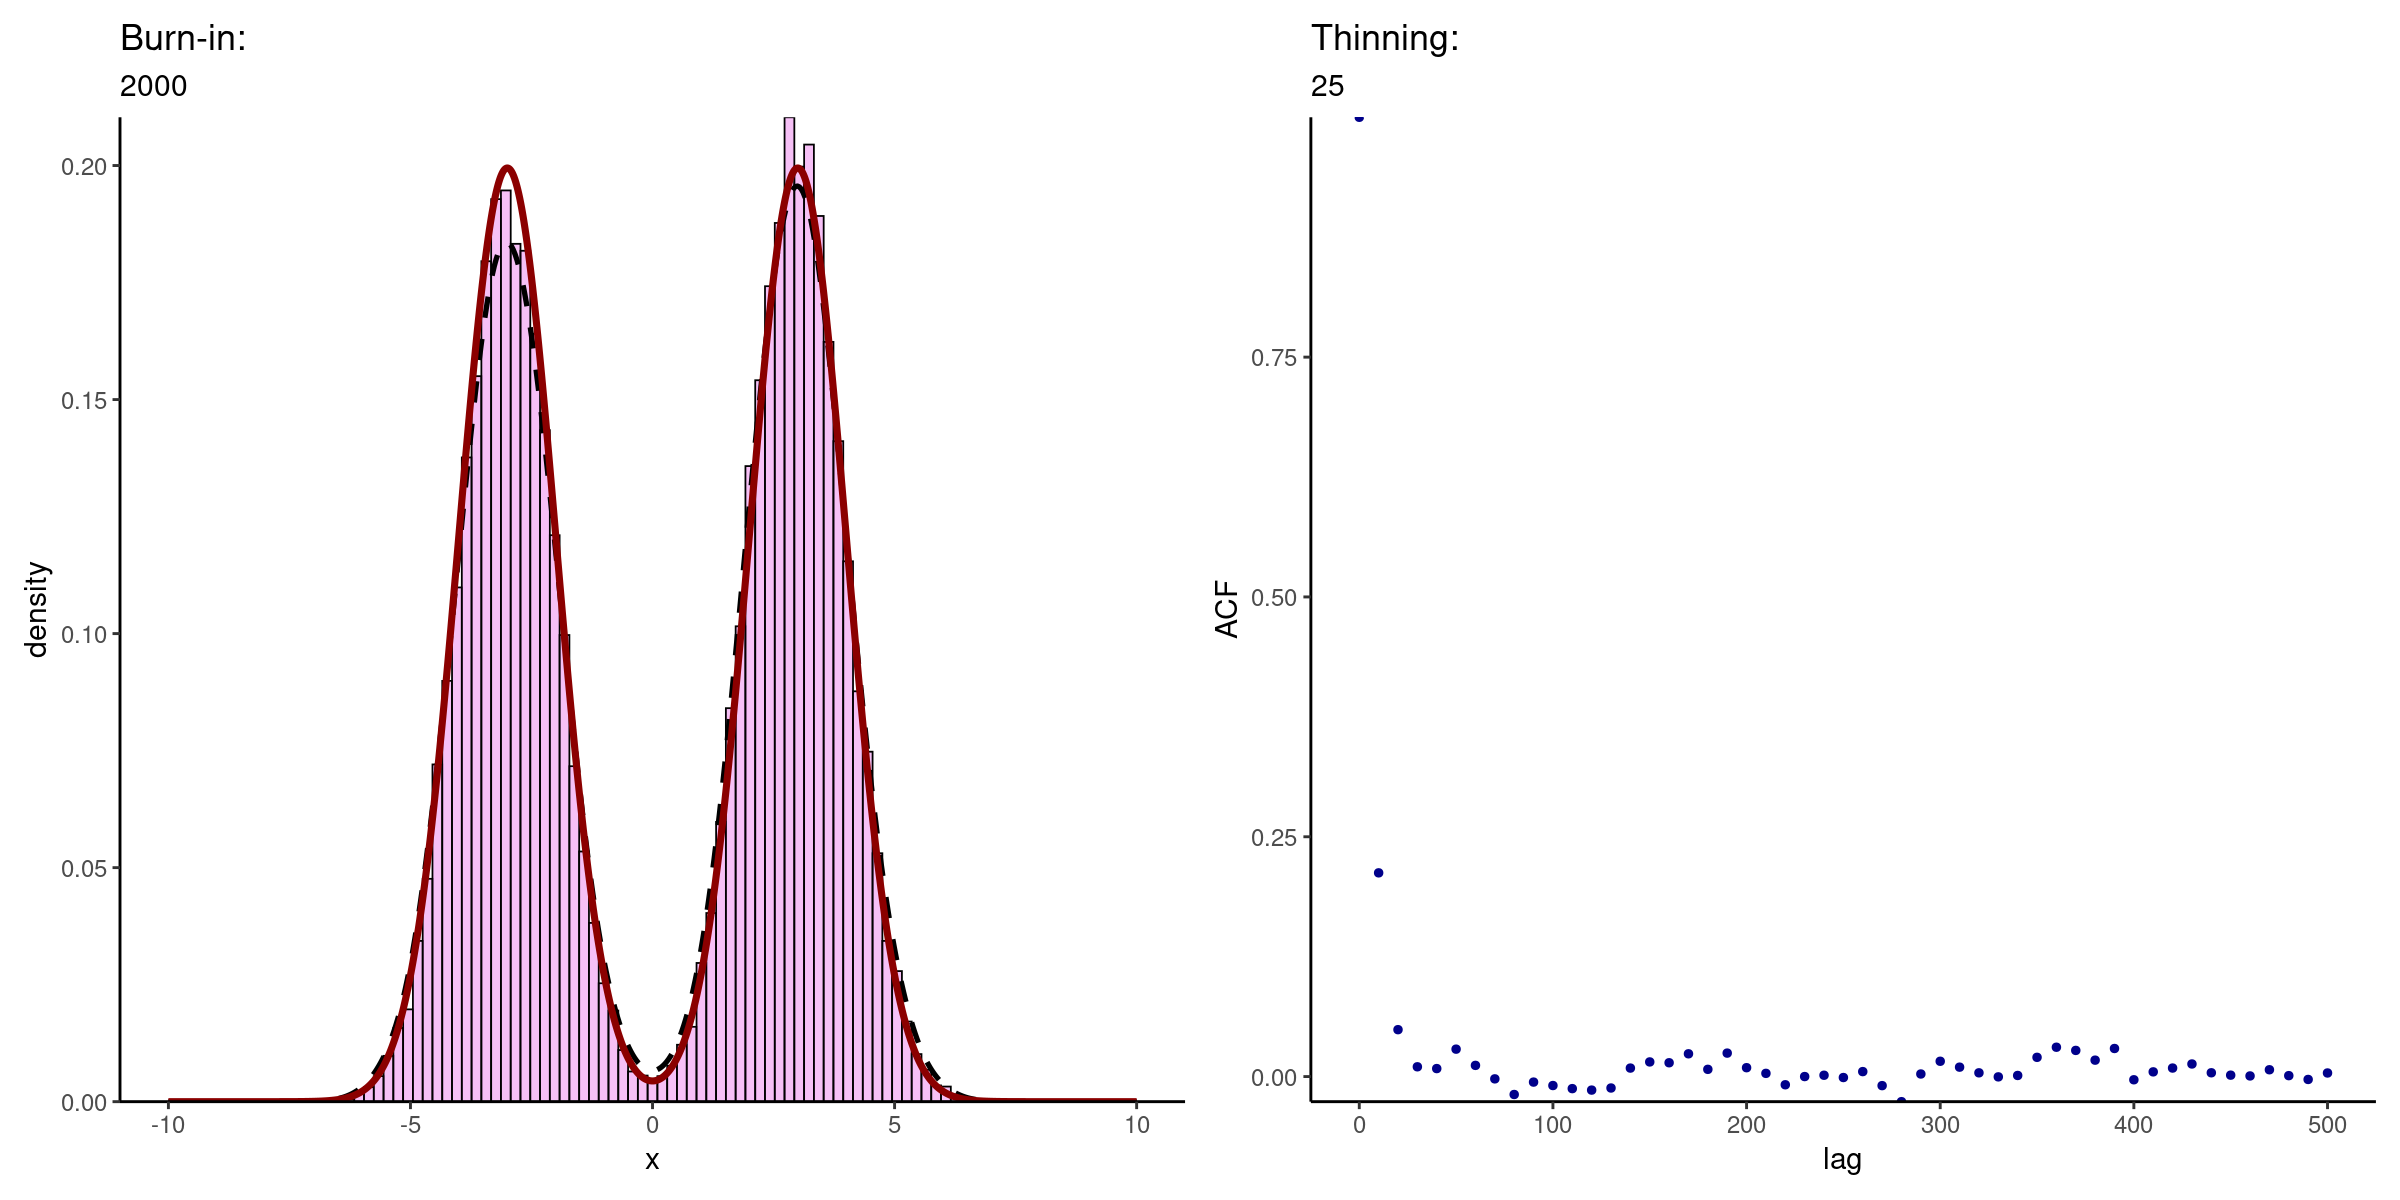

In [9]:
options(repr.plot.width=20, repr.plot.height=10)

burnin <- c(500, 2000)
thin <- c(10, 25)
for (i in burnin){
    for (j in thin){
        
        explore(theta_init, sample_sig, n_sample, i, j)
        
    }
}

Thinning = 10 has longer correlated region, so this is not a good option. If we consider two possibilities for burn-in with set thinning (thinning = 25), then we can see that there is not a big difference between burn-in 500 and 2000: with burn-in = 2000 autocorrelation goes to 0 only slightly faster. In the end, the best pair appears to be thinning = 25 and burn-in = 2000, however, if we want to save computing resources we can set burn-in to 500 and get a similar result.

# Exercise 2

### - the European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having performed a scientific evaluation of the veccines efficacy. The following vaccines are currently authorized for use in the European Union:
- Comirnaty (BioNTech and Pfizer)
- VCOVID-19 Vaccine Valneva
- Nuvaxovid (Novavax)
- Pikevax (Moderna)
- Vaxzeviria (AstraZeneca)
- Jcovden (Janssen)
- VidPrevtyn Beta (Sanofi Pasteur)
- Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.)

### - analyze the initial test data reported on the EMA Web site for the following early Vaccines
- Janssen [[1](https://www.ema.europa.eu/en/documents/overview/covid-19-vaccine-janssen-epar-medicine-overview_en.pdf)]

Results from a clinical trial involving people in the United States, South Africa and Latin American
countries found that Jcovden was effective at preventing COVID-19 in people from 18 years of age.
This study involved over 44,000 people. Half received a single dose of the vaccine and half were given
placebo (a dummy injection). People did not know if they had been given Jcovden or placebo.
The trial found a 67% reduction in the number of symptomatic COVID-19 cases after 2 weeks in
people who received Jcovden (116 cases out of 19,630 people) compared with people given placebo
(348 of 19,691 people). This means that the vaccine had a 67% efficacy.
Further data showed a rise in antibody levels when a booster dose was given after completion of a
primary course with Jcovden, an mRNA vaccine, or another adenoviral vector vaccine in people from
18 years of age.

- Moderna [[2](https://www.ema.europa.eu/en/documents/overview/spikevax-previously-covid-19-vaccine-moderna-epar-medicine-overview_en.pdf)]

Efficacy was calculated in around 28,000 people from 18 to 94 years of age who had no sign of previous infection.
Spikevax0F (COVID-19 mRNA Vaccine (nucleoside modified))
EMA/212866/2023 Page 3/6
The trial showed a 94.1% reduction in the number of symptomatic COVID-19 cases in the people who received the vaccine (11 out of 14,134 vaccinated people got COVID-19 with symptoms) compared
with people who received dummy injections (185 out of 14,073 people who received dummy injections got COVID-19 with symptoms). This means that the vaccine demonstrated a 94.1% efficacy in the trial. The trial also showed 90.9% efficacy in participants at risk of severe COVID-19, including those with chronic lung disease, heart disease, obesity, liver disease, diabetes or HIV infection.

- AstraZeneca [[3](https://www.ema.europa.eu/en/documents/overview/vaxzevria-previously-covid-19-vaccine-astrazeneca-epar-medicine-overview_en.pdf)]

Another study conducted in the United States, Peru and Chile involved around 26,000 people, of whom
21% were above 65 years of age. The participants received the second dose 4 weeks after the first one. The study showed a 74% reduction in the number of symptomatic COVID-19 cases in people given the vaccine (73 of 17,662 got COVID-19 with symptoms) compared with people given control
injections (130 of 8,550 got COVID-19 with symptoms). The study also showed that the vaccine efficacy of Vaxzevria in older people is comparable to that seen in younger people.

### and create a Markow Chain Monte Carlo JAGS or stan for calculating the efficacy of each Vaccine. Infere the 95% credibility interval.

In [10]:
making_tibble <- function(name, tot_vaccine, tot_placebo, pos_vaccine, pos_placebo){
    
    patient <- c(rep("Vaccine", tot_vaccine),
                 rep("Placebo", tot_placebo))
    
    tested <- c(rep("Pos", pos_vaccine),
                rep("Neg", tot_vaccine - pos_vaccine),
                rep("Pos", pos_placebo),
                rep("Neg", tot_placebo - pos_placebo))
    
    vaccine_tb <- tibble(tested = tested, patient = patient)
    print(name)
    print(table(vaccine_tb[[2]], vaccine_tb[[1]]))
    return(vaccine_tb)
}

In [11]:
making_list <- function(tb){
    
    dataList = list(
        tested = ifelse(tb$tested == "Neg", 0, 1),
        patient = as.integer(factor(tb$patient)),
        Ntot = nrow(tb),
        Nclass = nlevels(factor(tb$patient)) )
    
    return(dataList)
}

In [12]:
janssen_tb <- making_tibble('Janssen', 19630, 19691, 116, 348)
moderna_tb <- making_tibble('Moderna', 14134, 14073, 11, 185)
astrazeneca_tb <- making_tibble('AstraZeneca', 17662, 8550, 73, 130)


dataList_janssen <- making_list(janssen_tb)
dataList_moderna <- making_list(moderna_tb)
dataList_astrazeneca <- making_list(astrazeneca_tb)

[1] "Janssen"
         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19514   116
[1] "Moderna"
         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11
[1] "AstraZeneca"
         
            Neg   Pos
  Placebo  8420   130
  Vaccine 17589    73


In [13]:
model_COVID <- "model{
    for (i in 1:Ntot) {
    tested[i] ~ dbern(theta[patient[i]])
    }
    for (k in 1:Nclass) {
    theta[k] ~ dbeta(3, 100)
    }
}"

In [14]:
run_chain <- function(data, name){
    model <- jags.model(textConnection(model_COVID), data = data, quiet = TRUE)

    chains <- coda.samples(model, var = "theta", n.iter = 15000)

    df <- as.data.frame(as.mcmc(chains))
    colnames(df) <- c('Placebo', 'Vaccine')
    
    df$efficacy <- (1 - df$Vaccine/df$Placebo)*100
    
    cat('Vaccine:', name, '\n')
    return(df)
    }

In [15]:
moderna_chain <- run_chain(dataList_moderna, 'Moderna')
astrazeneca_chain <- run_chain(dataList_astrazeneca, 'AstraZeneca')
janssen_chain <- run_chain(dataList_janssen, 'Janssen')

Vaccine: Moderna 
Vaccine: AstraZeneca 
Vaccine: Janssen 


In [16]:
plotting_all <- function(chain, colour){
        quantile1 <- quantile(chain$efficacy, prob = 0.025)
        quantile2 <- quantile(chain$efficacy, prob = 0.975)
    
        eff <-  ggplot(data = chain) +
                geom_histogram(aes(x=efficacy, y=after_stat(density)), bins=100, color = 'black',
                           fill=colour, alpha=0.5) +
                geom_vline(aes(xintercept = quantile1, col='95% c.i.'),
                           linewidth = 1.2, linetype='dashed') +
                geom_vline(aes(xintercept = quantile2, col='95% c.i.'),
                           linewidth = 1.2, linetype='dashed') +
                scale_y_continuous(expand = c(0, 0)) +
                theme_classic(base_size=18)
    
    print(eff)
    
}

Moderna vaccine 
Mean efficacy: 92.6 % 


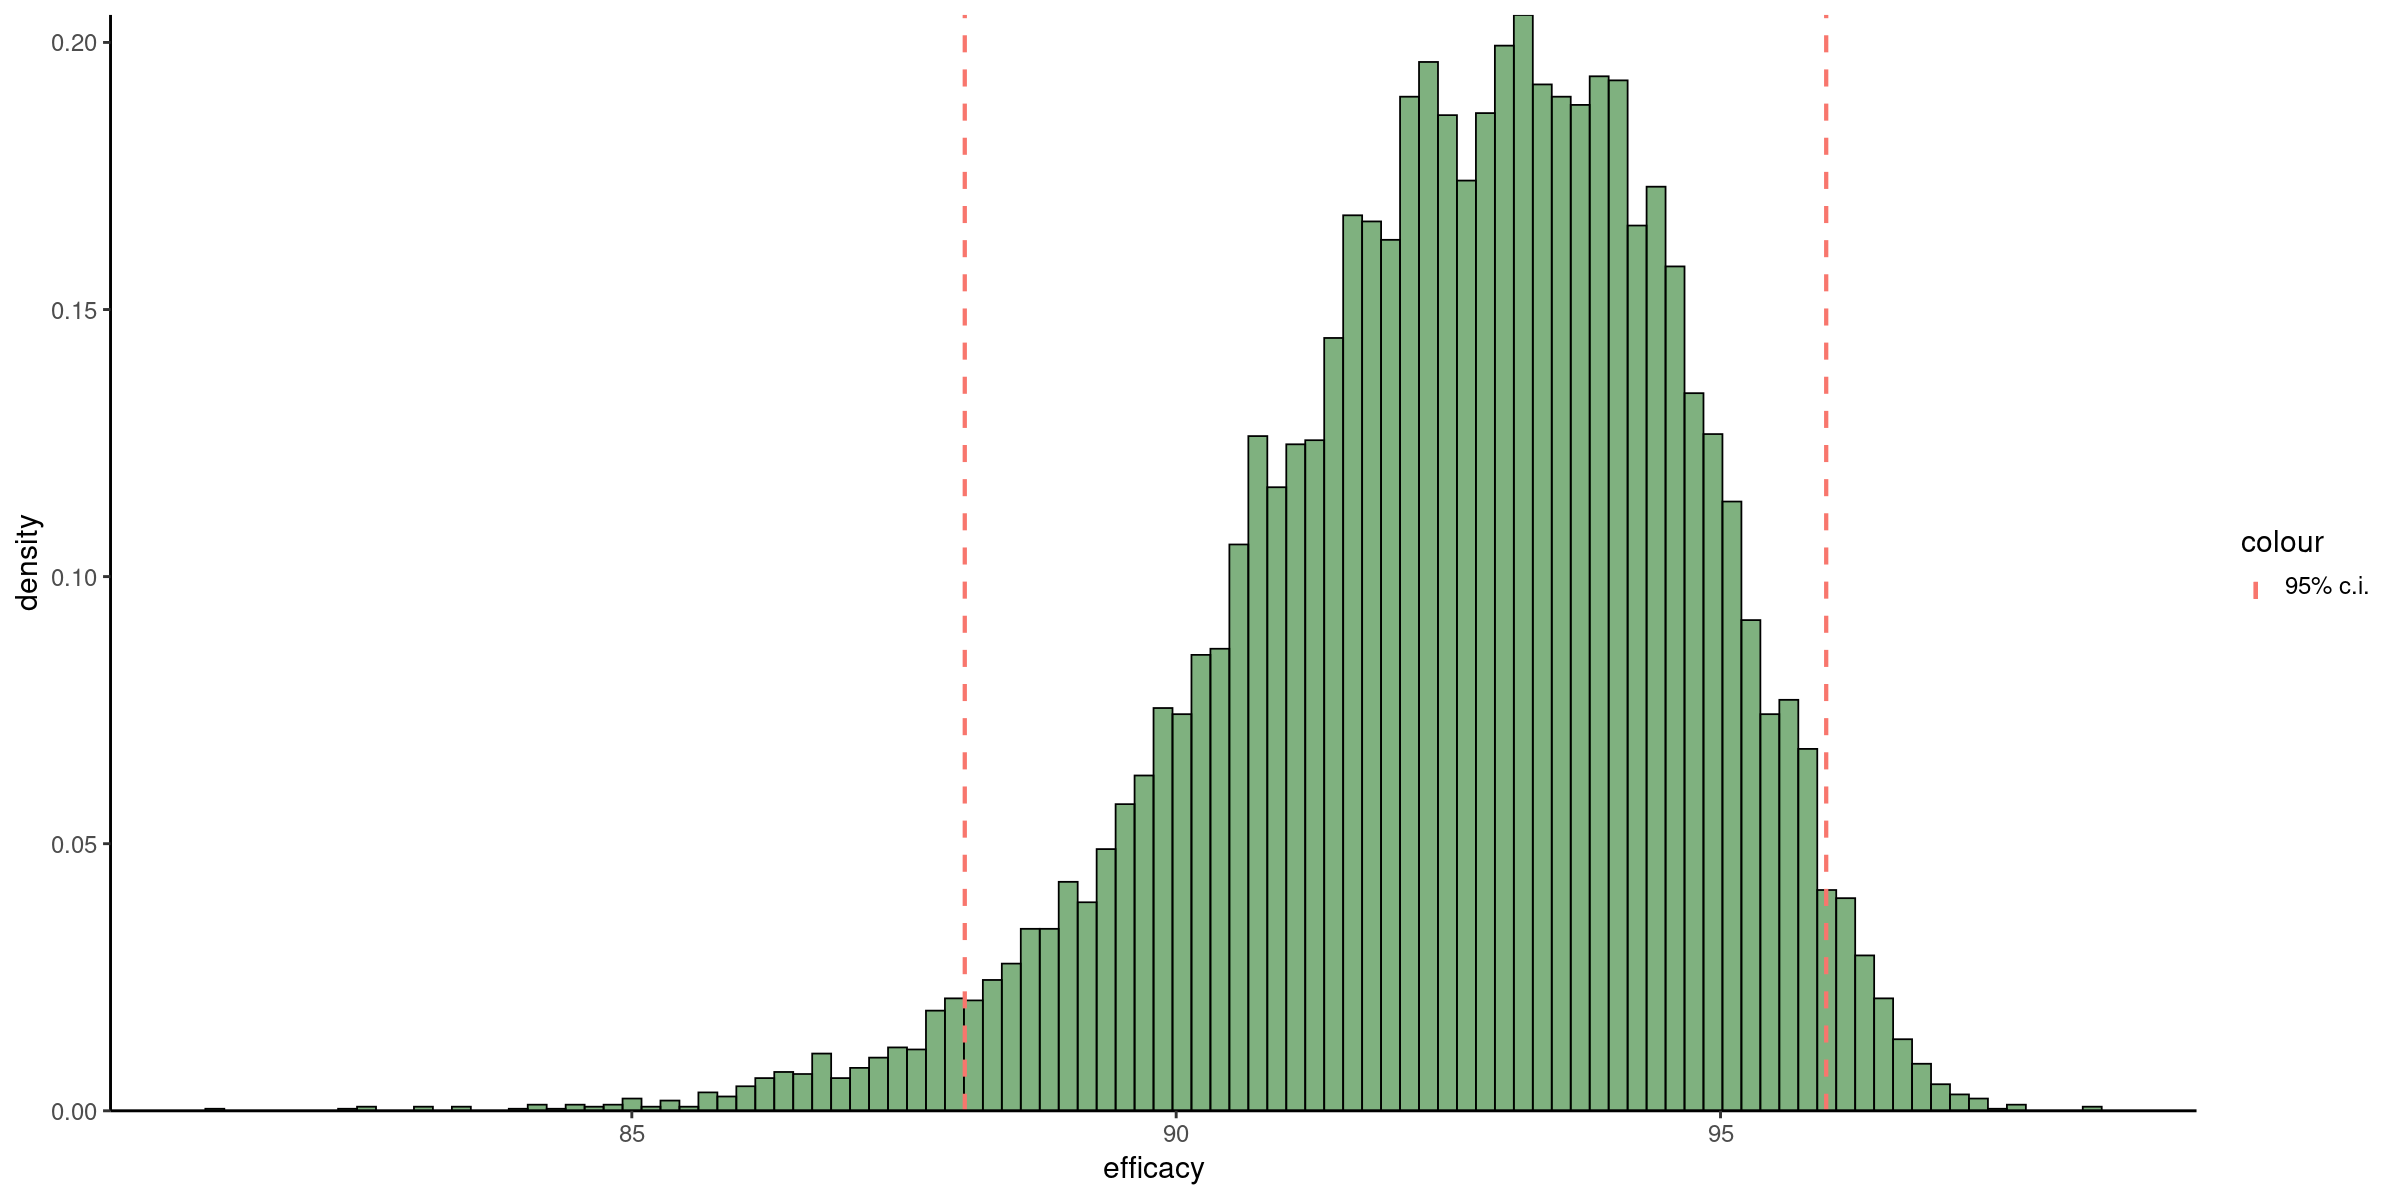

In [17]:
cat('Moderna vaccine \n')
cat('Mean efficacy:', round(mean(moderna_chain$efficacy),1), '% \n')
plotting_all(moderna_chain, 'darkgreen')

AstraZeneca vaccine 
Mean efficacy: 72 % 


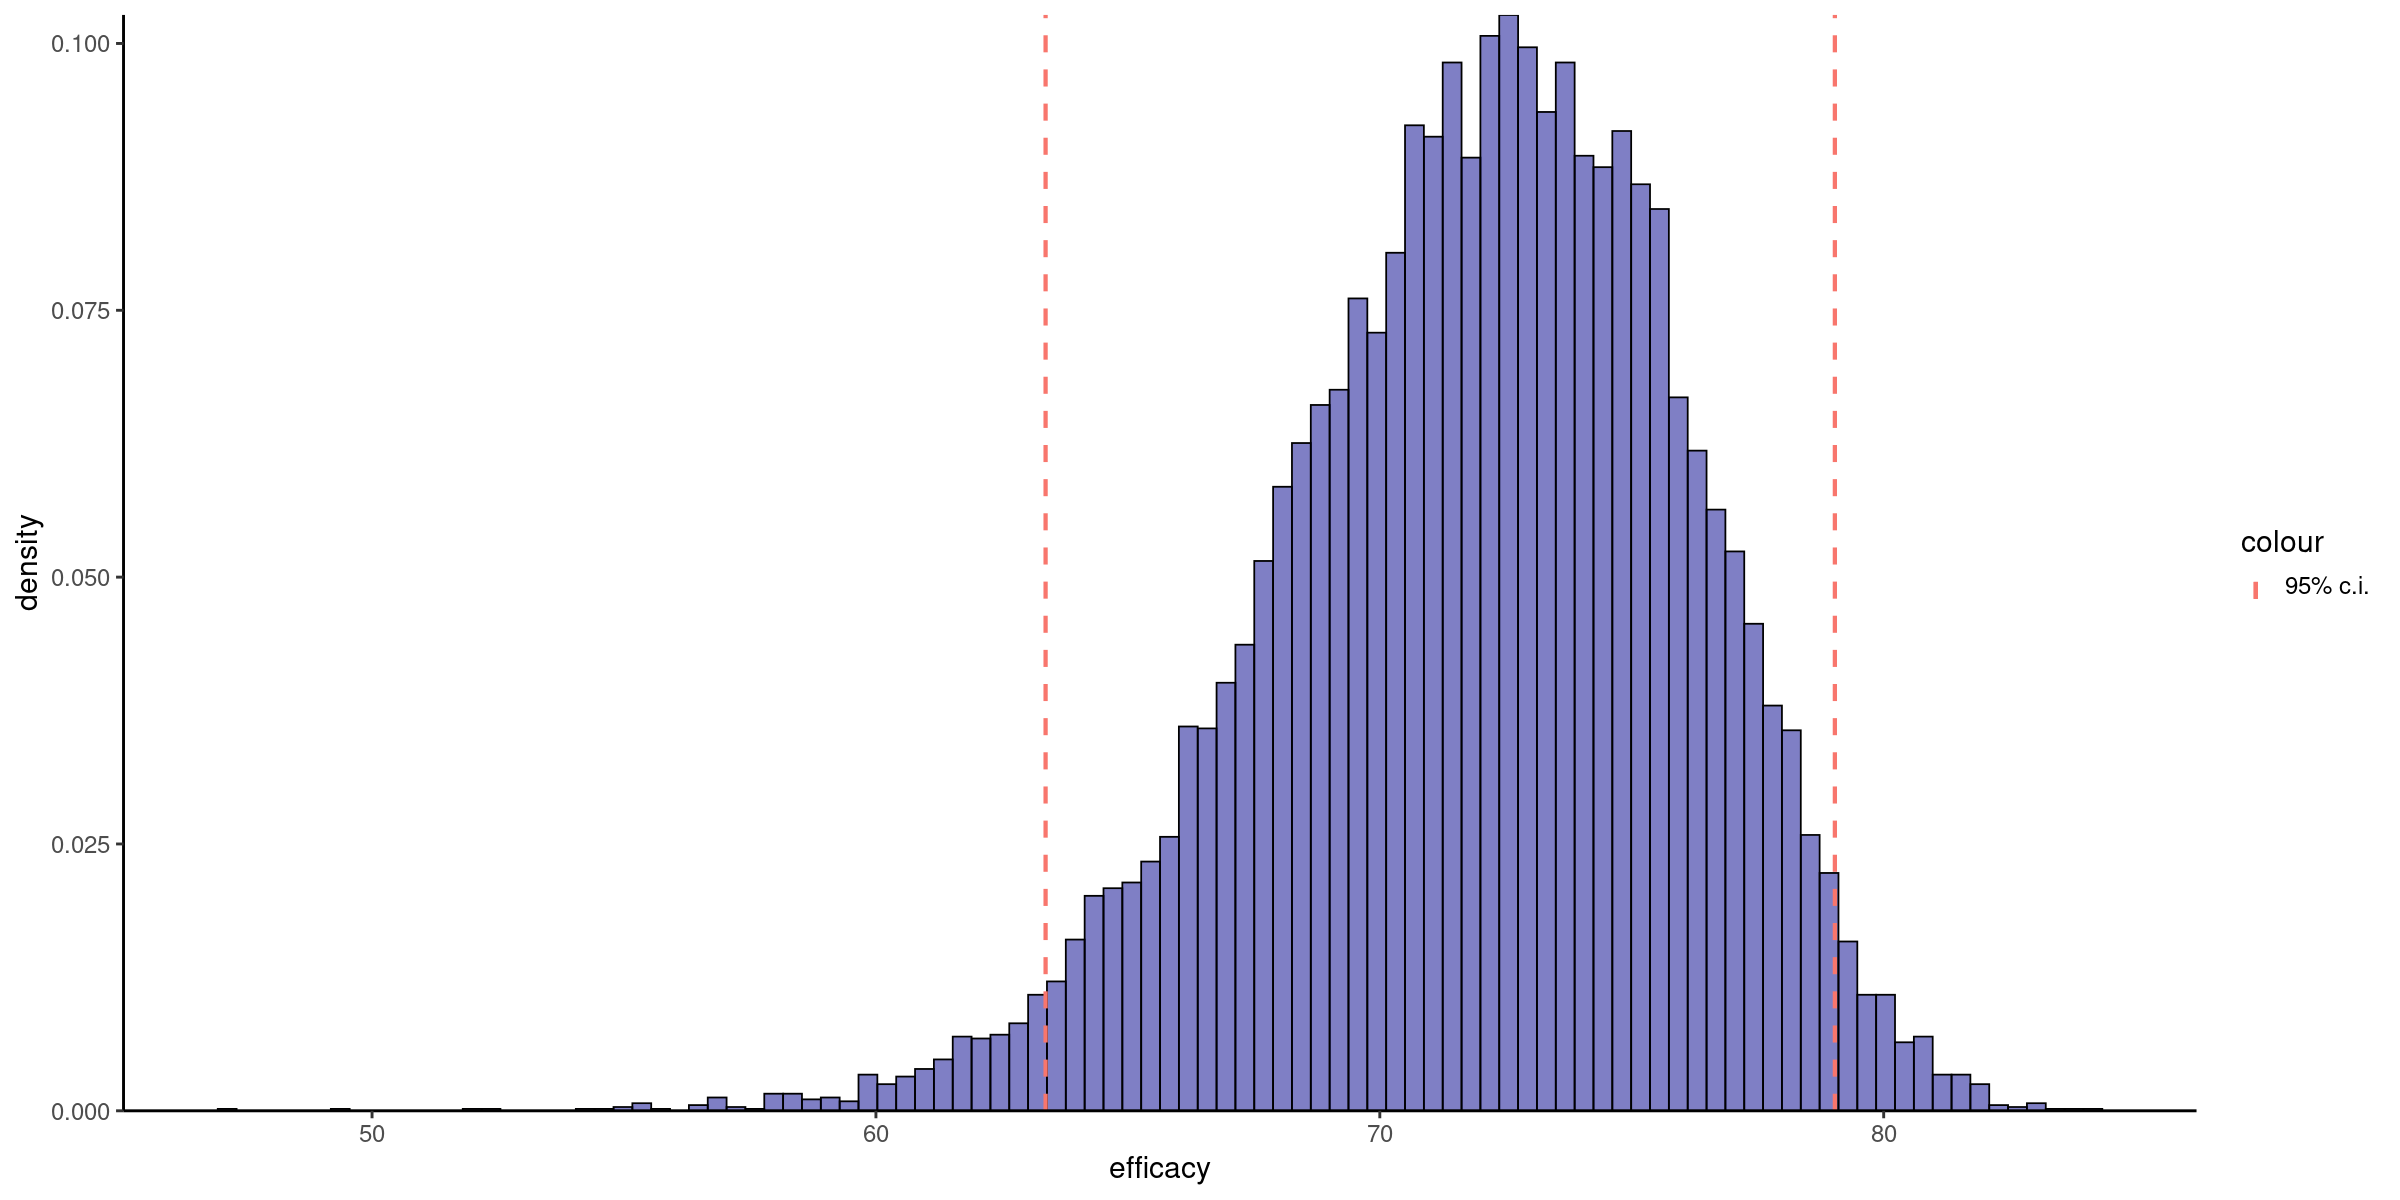

In [18]:
cat('AstraZeneca vaccine \n')
cat('Mean efficacy:', round(mean(astrazeneca_chain$efficacy),1), '% \n')
plotting_all(astrazeneca_chain, 'darkblue')

Janssen vaccine 
Mean efficacy: 66 % 


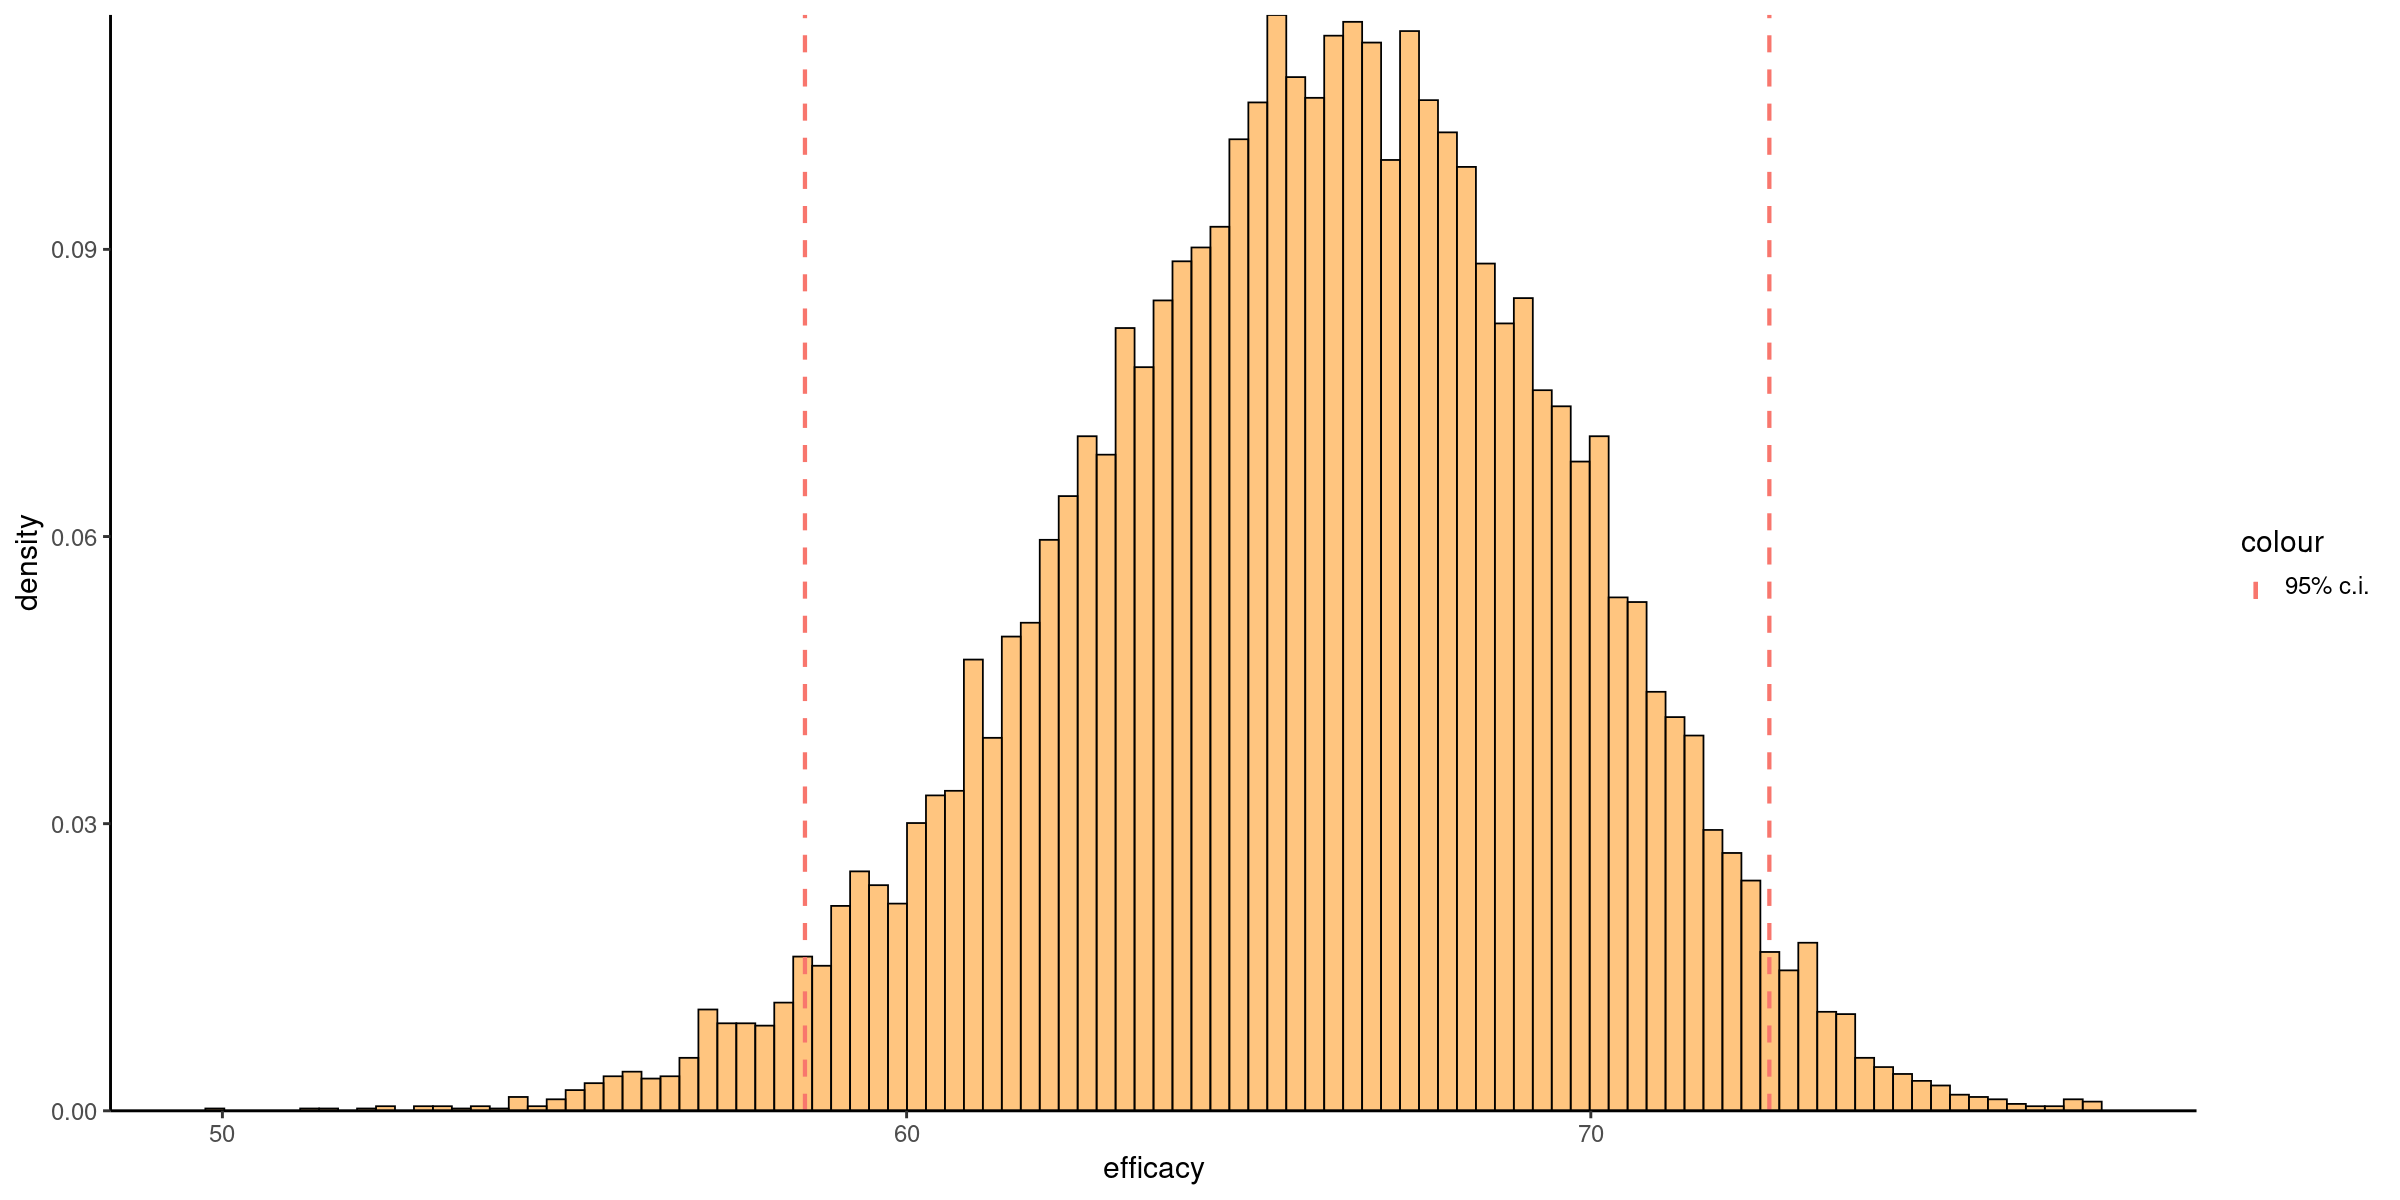

In [19]:
cat('Janssen vaccine \n')
cat('Mean efficacy:', round(mean(janssen_chain$efficacy),1), '% \n')
plotting_all(janssen_chain, 'darkorange')

Mean efficacy for all the vaccines is a little bit lower than in the EMA documents, but all these numbers from EMA documents fall in the 95% credibility interval.

# Exercise 3

### • according to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available [[4](https://ourworldindata.org/covid-vaccinations)]

### • the European Centre for Disease Prevention and Control published a downloadable file [[5](https://github.com/owid/covid-19-data/tree/master/public/data)] containing information on COVID-19 vaccination in the EU/EEA.

### • analyze the data and produce the following plots:
### - number of vaccinated people (cumulative, daily and week average)

In [20]:
covid <- read_csv("owid-covid-data.csv")

Rows: 314912 Columns: 67
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): iso_code, continent, location, tests_units
dbl  (62): total_cases, new_cases, new_cases_smoothed, total_deaths, new_dea...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
glimpse(covid)

Rows: 314,912
Columns: 67
$ iso_code                                   <chr> "AFG", "AFG", "AFG", "AFG",…
$ continent                                  <chr> "Asia", "Asia", "Asia", "As…
$ location                                   <chr> "Afghanistan", "Afghanistan…
$ date                                       <date> 2020-01-03, 2020-01-04, 20…
$ total_cases                                <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_cases                                  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_cases_smoothed                         <dbl> NA, NA, NA, NA, NA, 0, 0, 0…
$ total_deaths                               <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_deaths                                 <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_deaths_smoothed                        <dbl> NA, NA, NA, NA, NA, 0, 0, 0…
$ total_cases_per_million                    <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_cases_per_million                      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_cases_sm

Cumulative:

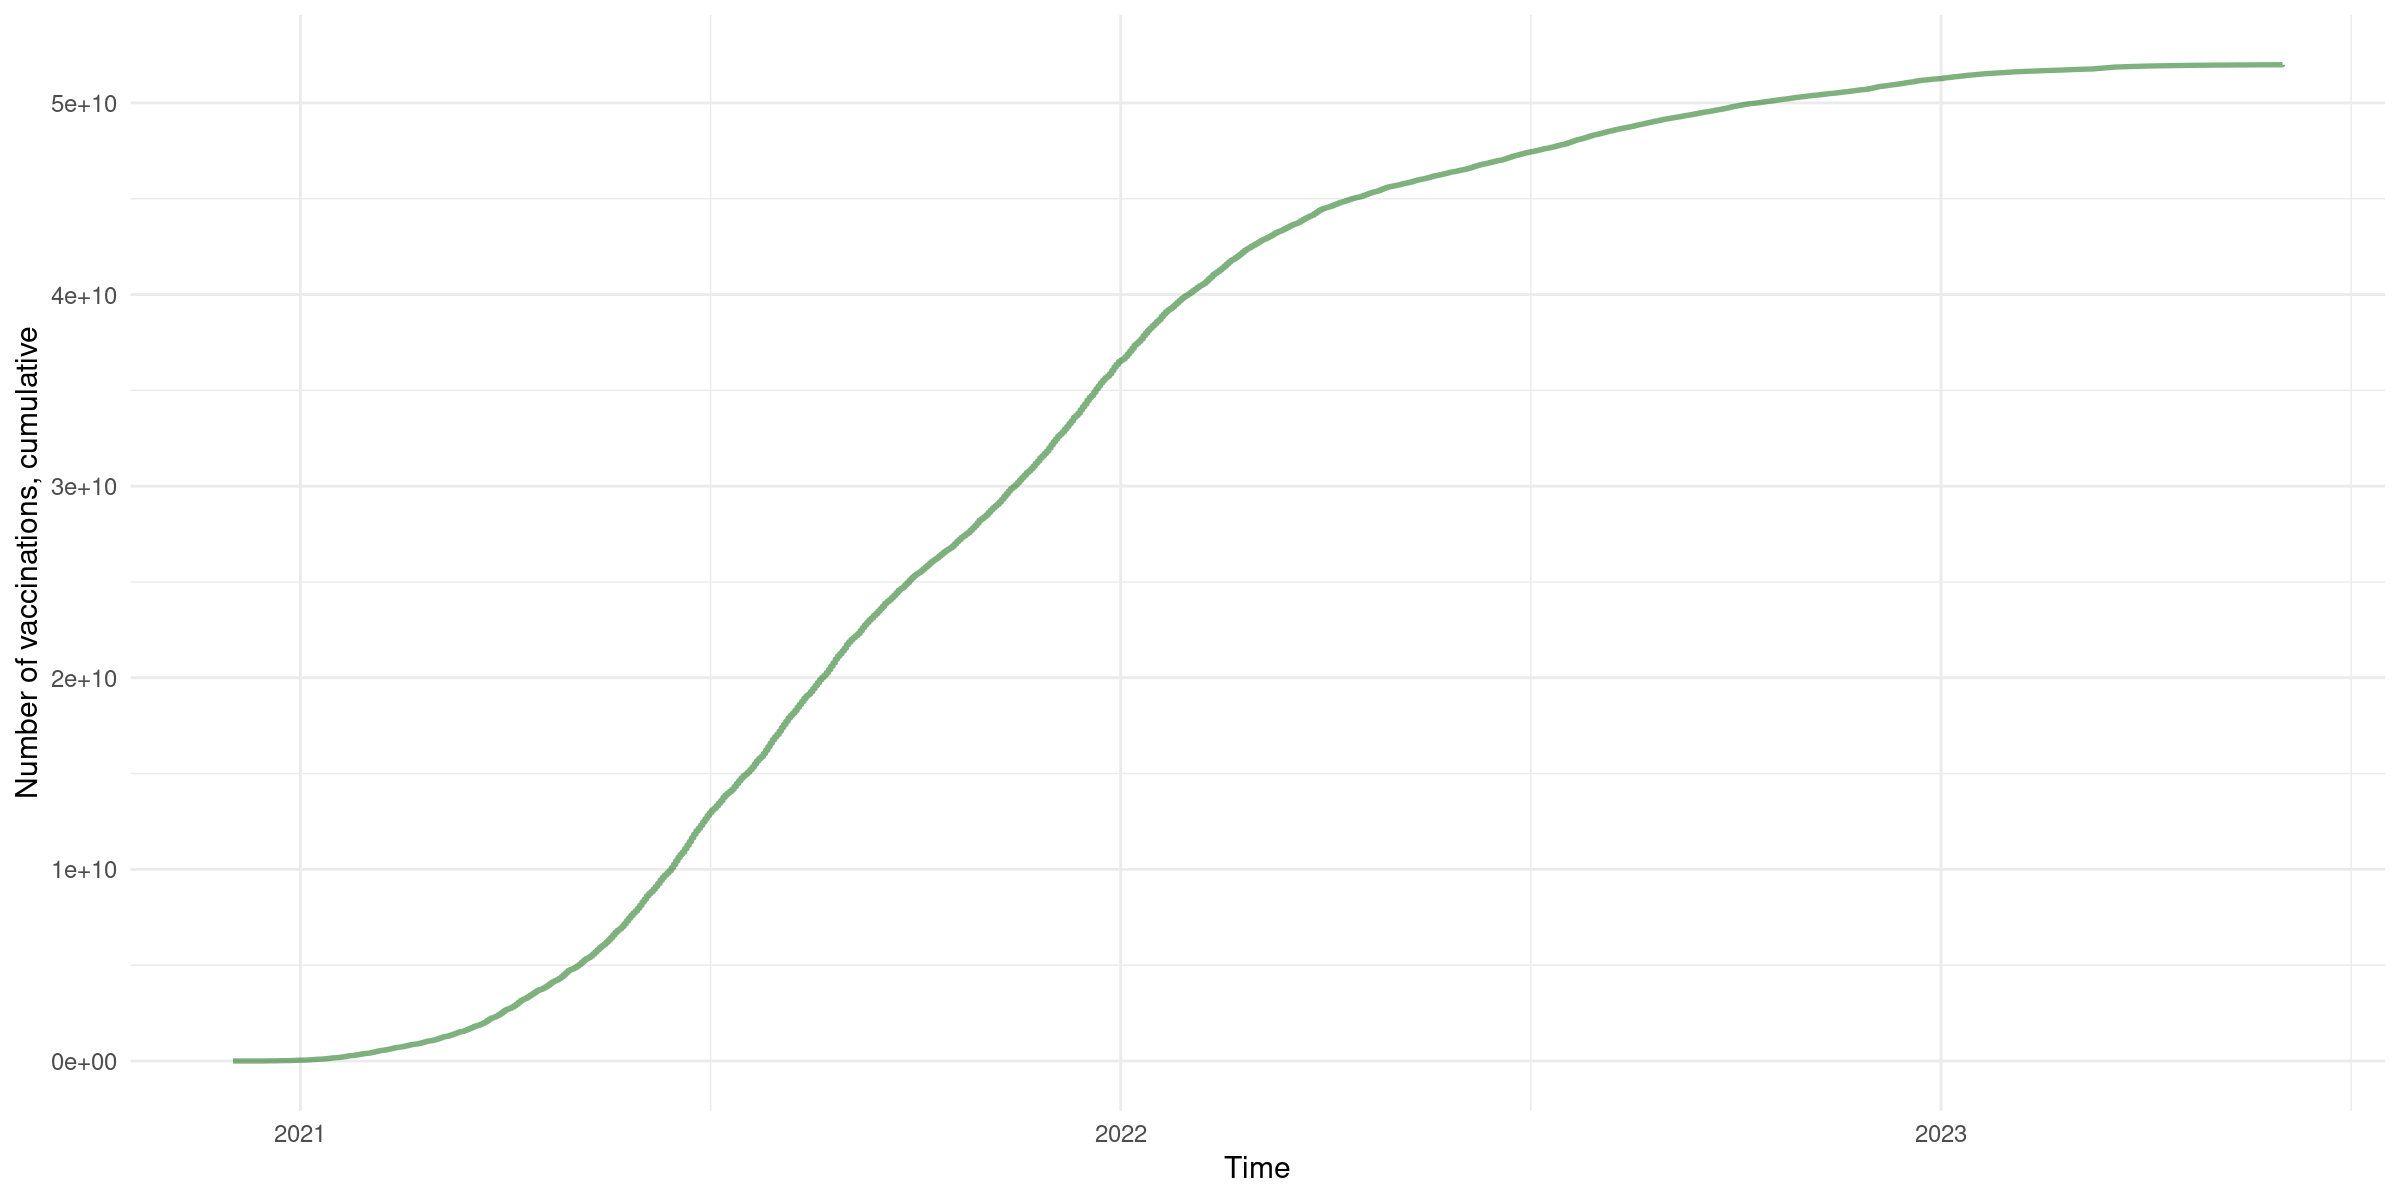

In [22]:
covid %>%
    select(date, new_vaccinations) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(cs = cumsum(new_vaccinations)) %>%
    ggplot(aes(x = date, y = cs)) +
    geom_line(col='darkgreen', alpha=0.5, linewidth=1.5) +
    theme_minimal(base_size=18) +
    labs(x="Time", y="Number of vaccinations, cumulative")

Daily results:

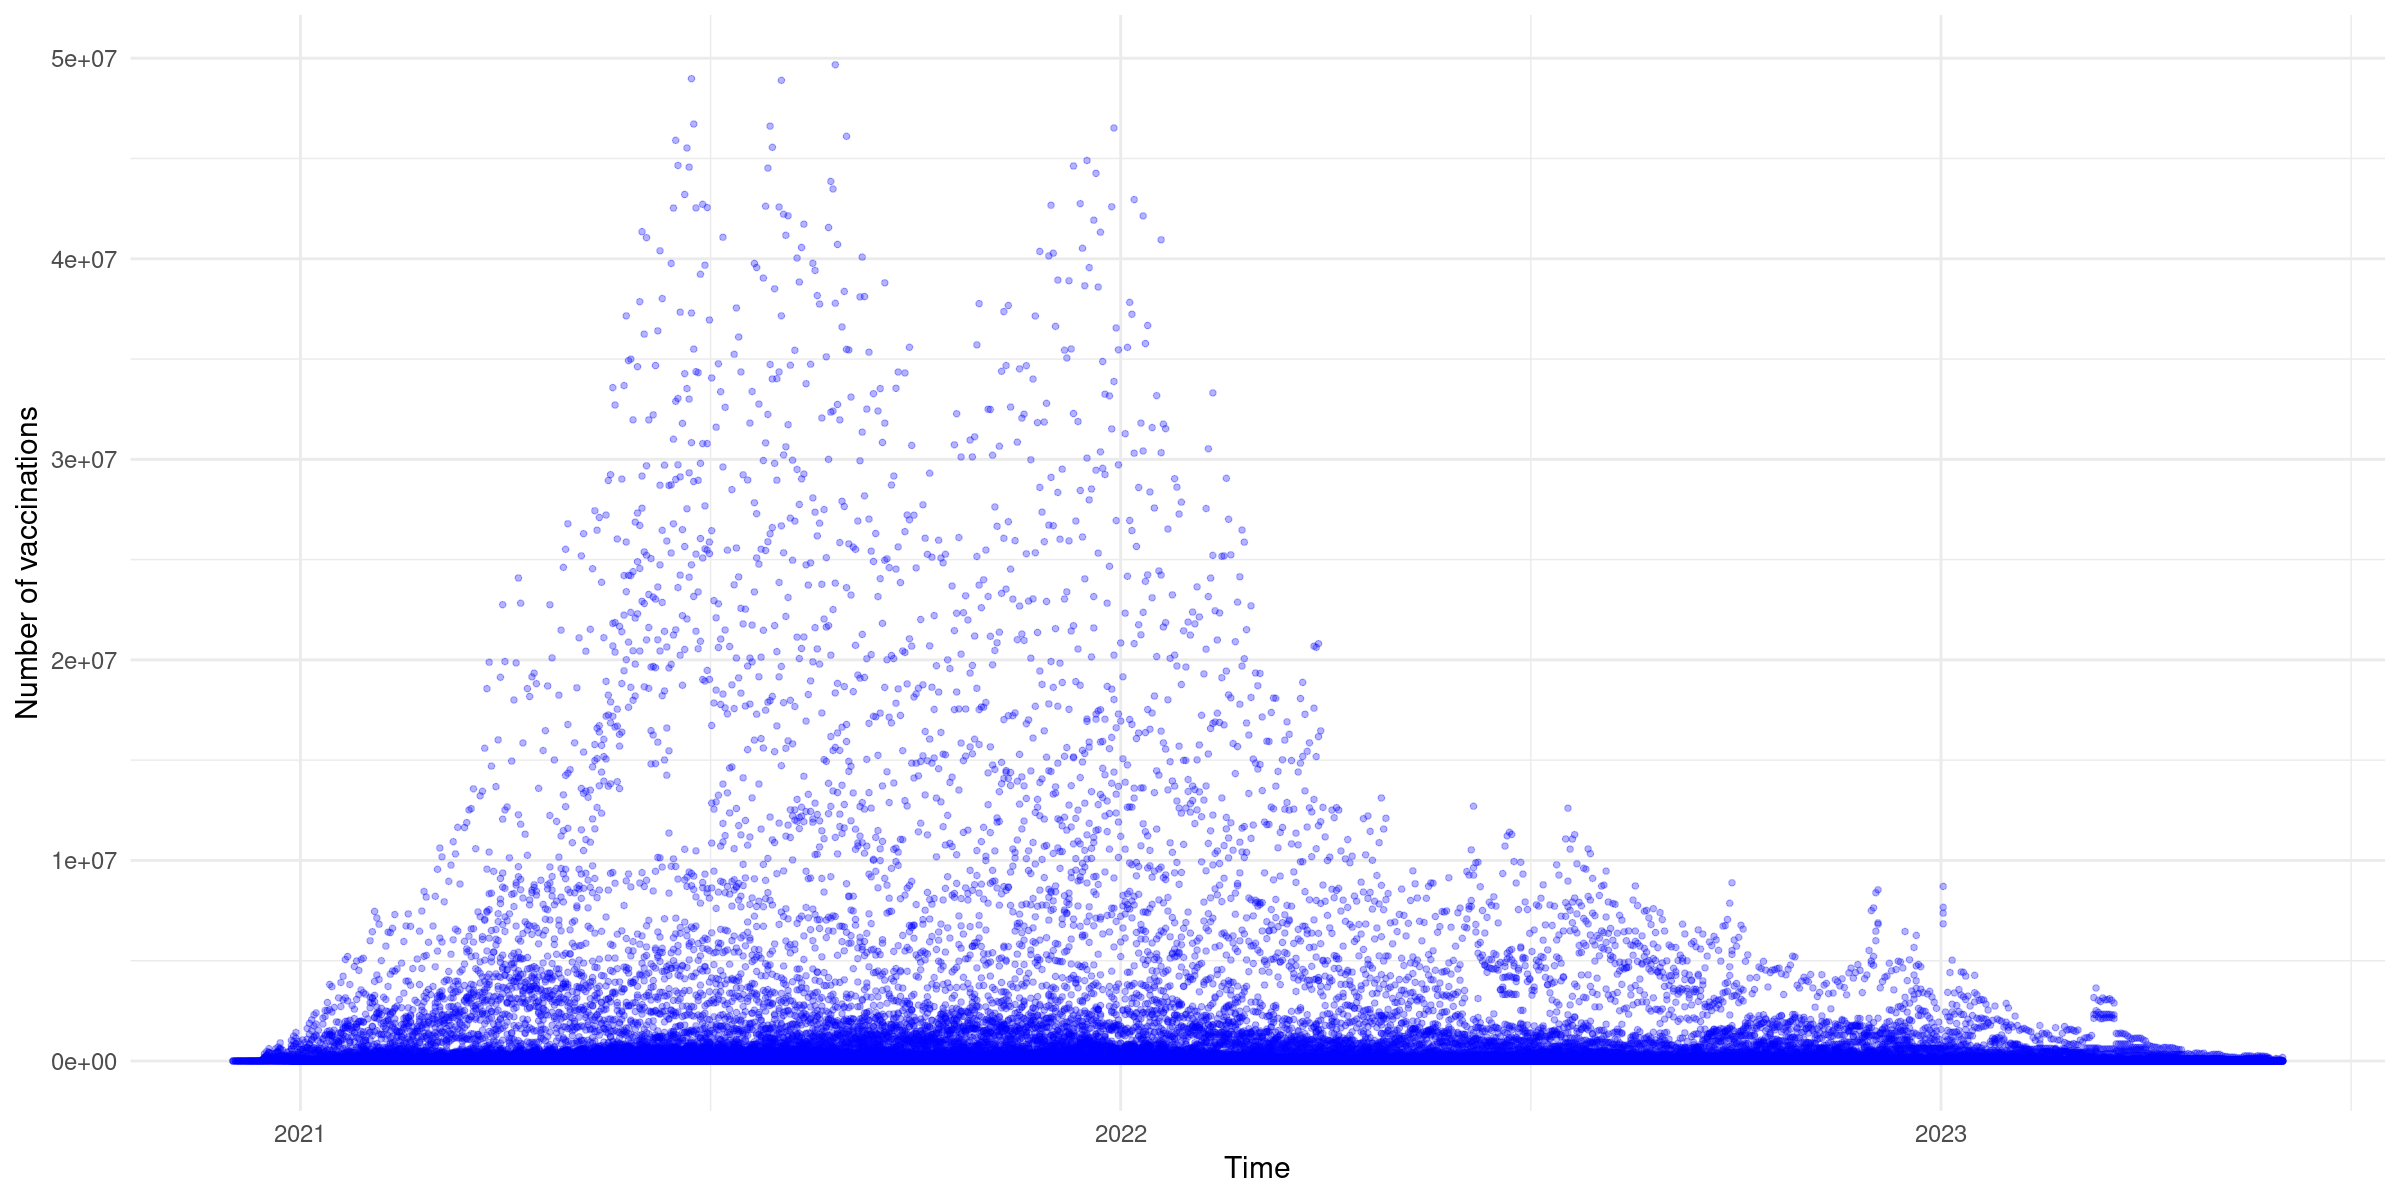

In [23]:
covid %>%
    select(date, new_vaccinations) %>%
    na.omit() %>%
    arrange(date) %>%
    ggplot(aes(x = date, y = new_vaccinations)) +
    geom_point(col='blue', alpha=0.3) +
    theme_minimal(base_size=18) +
    labs(x="Time", y="Number of vaccinations")

Week average:


Firstly, I compute a week average, for this I use a variable year_week, that stores information both about the yaer and a week.

In [24]:
covid %>%
    select(date, new_vaccinations) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(year_week = ifelse(week(date) < 10,
        as.integer(paste(as.character(year(date)),'0',
                         as.character(week(date)), sep='')),
        as.integer(paste(as.character(year(date)),
                         as.character(week(date)), sep=''))) ) %>%
     summarise(mean = mean(new_vaccinations), .by=year_week) -> help_df

Secondly, I link year_week variable to a "normal" date (max date of the week in the dataset).

In [25]:
covid %>%
    select(date, new_vaccinations) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(year_week = ifelse(week(date) < 10,
        as.integer(paste(as.character(year(date)),'0',
                         as.character(week(date)), sep='')),
        as.integer(paste(as.character(year(date)),
                         as.character(week(date)), sep=''))) ) %>%
    mutate(week=week(date)) %>%
    filter(year_week %in% help_df$year_week) %>%
    summarise(date = max(date), .by=year_week) %>%
    select(date) -> data

help_df$date <- data$date

Finally, I can plot a week average.

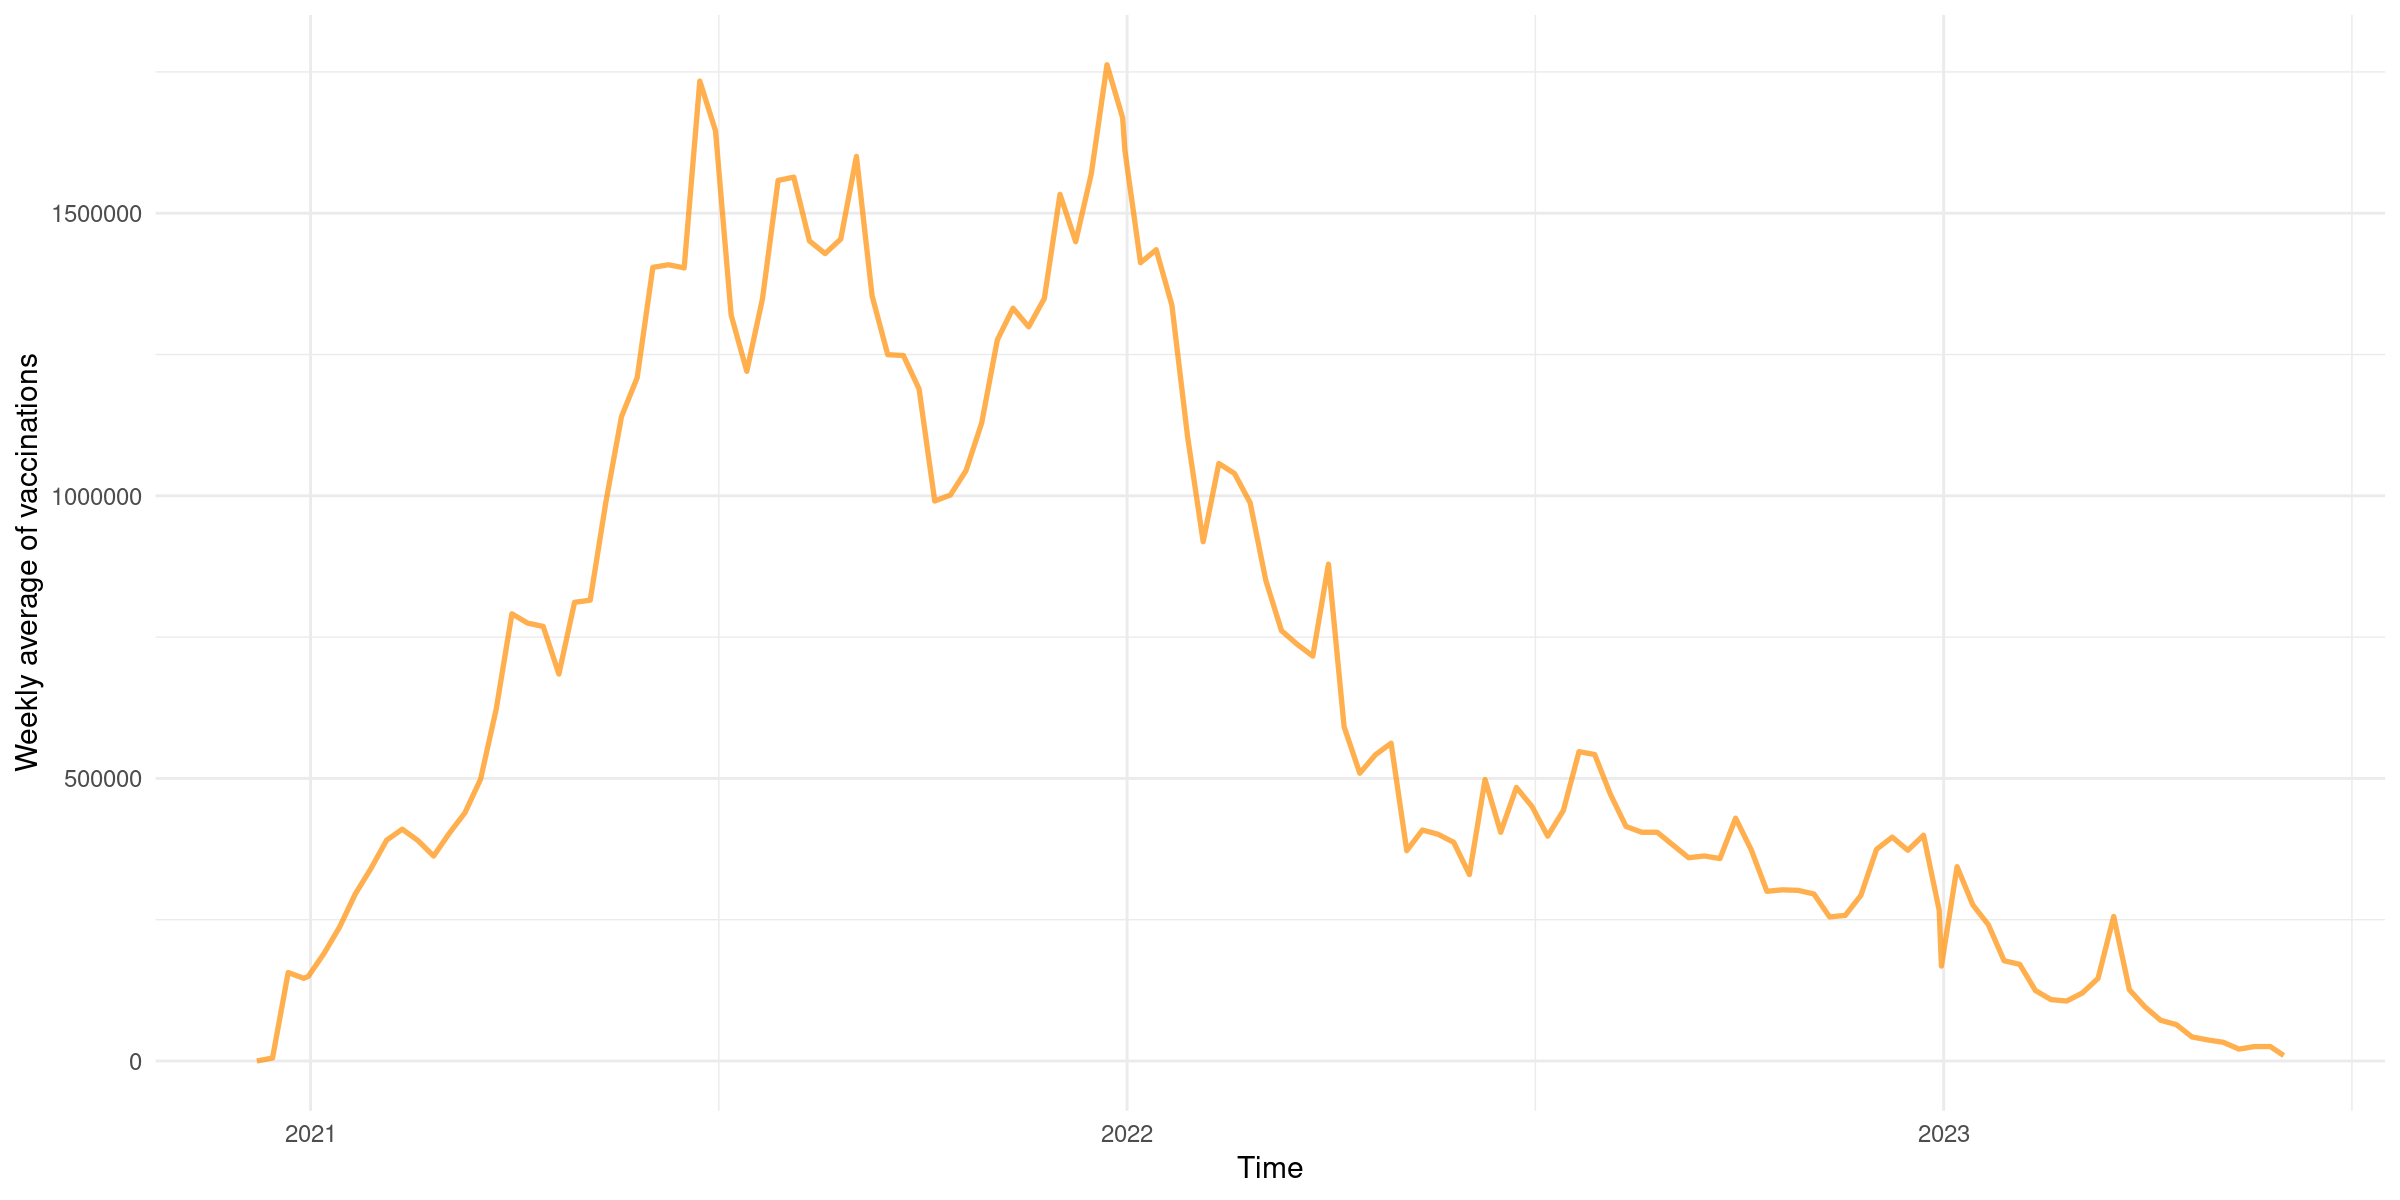

In [26]:
help_df %>%
    select(date, mean) %>%
    ggplot(aes(x = date, y = mean)) +
    geom_line(col='darkorange', alpha=0.7, linewidth=1.5) +
    theme_minimal(base_size=18) +
    labs(x="Time", y="Weekly average of vaccinations")

### - number of confirmed deaths by COVID-19, both cumulative and weekly average


Cumulative death:

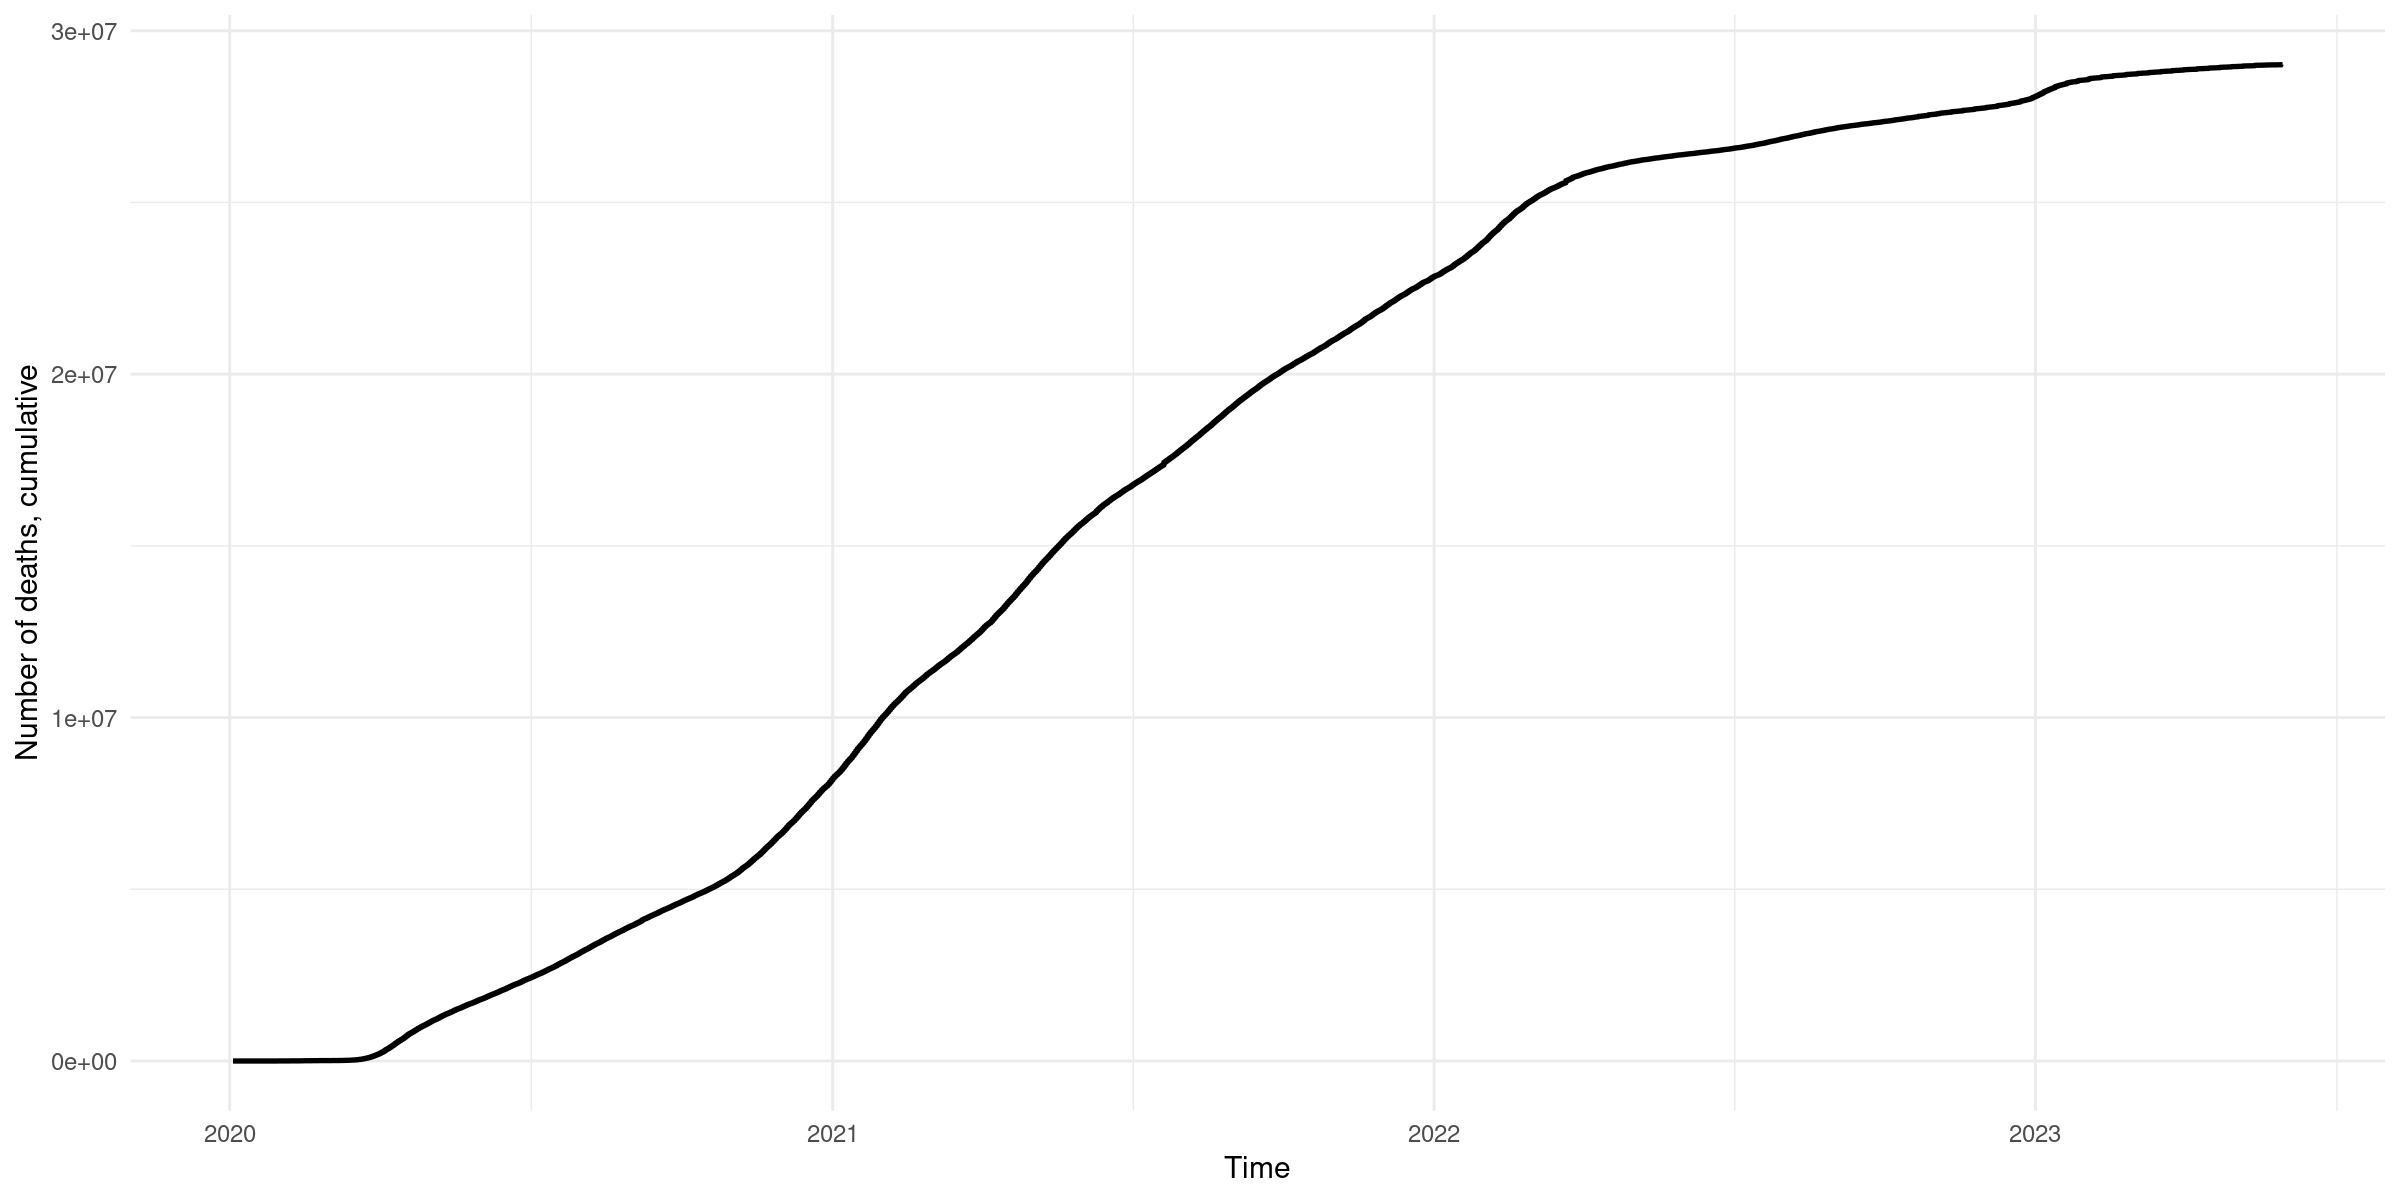

In [27]:
covid %>%
    select(date, new_deaths) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(cs = cumsum(new_deaths)) %>%
    ggplot(aes(x = date, y = cs)) +
    geom_line(col='black', linewidth=1.5) +
    theme_minimal(base_size=18) +
    labs(x="Time", y="Number of deaths, cumulative")

For the week average I follow the same steps as before:

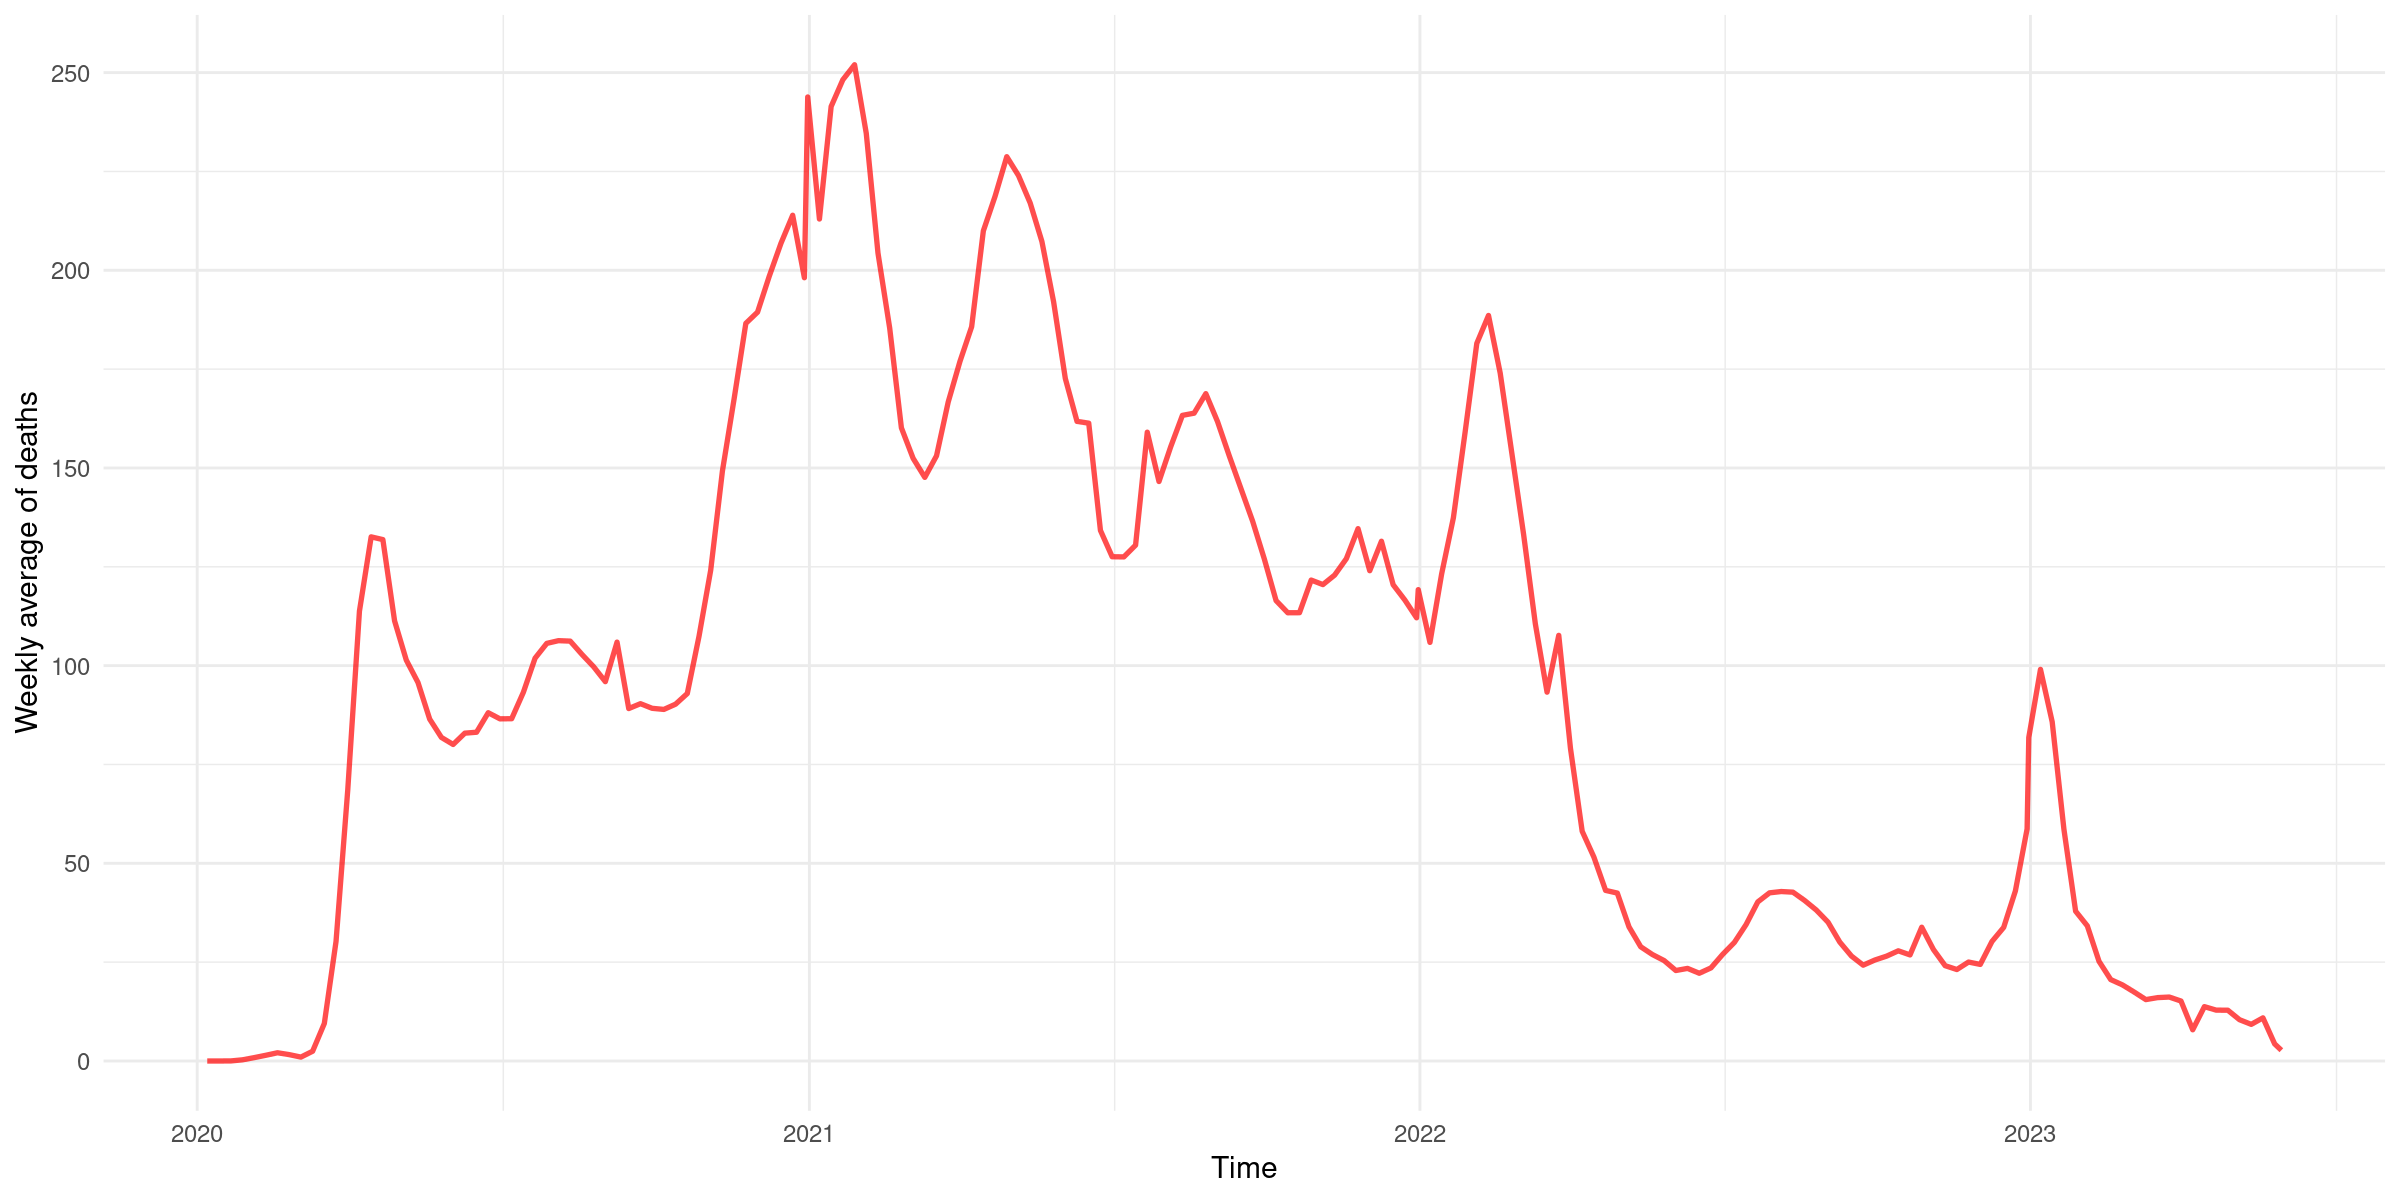

In [28]:
covid %>%
    select(date, new_deaths) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(year_week = ifelse(week(date) < 10,
        as.integer(paste(as.character(year(date)),'0',
                         as.character(week(date)), sep='')),
        as.integer(paste(as.character(year(date)),
                         as.character(week(date)), sep=''))) ) %>%
     summarise(mean = mean(new_deaths), .by=year_week) -> help_df2


covid %>%
    select(date, new_deaths) %>%
    na.omit() %>%
    arrange(date) %>%
    mutate(year_week = ifelse(week(date) < 10,
        as.integer(paste(as.character(year(date)),'0',
                         as.character(week(date)), sep='')),
        as.integer(paste(as.character(year(date)),
                         as.character(week(date)), sep=''))) ) %>%
    mutate(week=week(date)) %>%
    filter(year_week %in% help_df2$year_week) %>%
    summarise(date = max(date), .by=year_week) %>%
    select(date) -> data2

help_df2$date <- data2$date


help_df2 %>%
    select(date, mean) %>%
    ggplot(aes(x = date, y = mean)) +
    geom_line(col='red', alpha=0.7, linewidth=1.5) +
    theme_minimal(base_size=18) +
    labs(x="Time", y="Weekly average of deaths")